In [1]:
import os, sys
# print(os.path.abspath('..'))

import glob
from pathlib import Path

from copy import deepcopy

import json
import math
import cv2
import numpy as np
import pandas
import torch

from skimage import data, filters, segmentation
from skimage.filters.rank import entropy
from skimage.morphology import disk, ball, black_tophat, white_tophat
from skimage.measure import shannon_entropy, label, regionprops
from skimage.morphology import square, disk
from skimage.io import imread

from scipy.signal import find_peaks
from astropy.io import fits

from tqdm.notebook import tqdm

import concurrent.futures
import multiprocessing
from itertools import repeat

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
%matplotlib ipympl


# Visualize the generated/predicted Masks 

In [2]:
dataset_root = "../../datasets/segmentation/ManualAnnotation"

seg_types = ['GroundTruth_single']
st = 25
tophat_thresh= range(250, 500 + st, st)
gen_seg_types = [f'2023_T{t}_fgbg' for t in tophat_thresh]
print(gen_seg_types)

image_folder     = os.path.join(dataset_root, 'image')
image_lst = sorted(glob.glob(os.path.join(image_folder, '**/*.FTS'), recursive=True))
print(len(image_lst))

gt_folder        = os.path.join(dataset_root, 'GroundTruth_single')
gt_lst = sorted(glob.glob(os.path.join(gt_folder, '*.png')))

generated_folders = {t : os.path.join(dataset_root, t) for t in gen_seg_types}
generated_lsts = {t : sorted(glob.glob(os.path.join(generated_folders[t], '*.png'))) for t in gen_seg_types}


dir_lst = [
    # T500
    Path('../../outputs/2023-01-19/23-41-01_2013-15_UNet_T500_StepLR_epoch_1_run0'),
    Path('../../outputs/2023-01-20/00-37-54_2013-15_UNet_T500_StepLR_epoch_1_run2'),
    Path('../../outputs/2023-01-20/03-38-03_2013-15_UNet_T500_StepLR_epoch_1_run3'),
    Path('../../outputs/2023-01-20/05-39-51_2013-15_UNet_T500_StepLR_epoch_1_run4'),
    Path('../../outputs/2023-01-20/19-11-13_2013-15_UNet_T500_StepLR_epoch_1_run5'),
    # T475
    Path('../../outputs/2023-01-20/22-40-27_2013-15_UNet_T475_StepLR_epoch_1_run0'),
    Path('../../outputs/2023-01-21/00-00-49_2013-15_UNet_T475_StepLR_epoch_1_run2'),
    Path('../../outputs/2023-01-20/23-27-58_2013-15_UNet_T475_StepLR_epoch_1_run3'),
    Path('../../outputs/2023-01-21/06-22-01_2013-15_UNet_T475_StepLR_epoch_1_run4'),
    Path('../../outputs/2023-01-21/06-23-01_2013-15_UNet_T475_StepLR_epoch_1_run5'),
    # T450
    Path('../../outputs/2023-01-19/23-43-05_2013-15_UNet_T450_StepLR_epoch_1_run0'),
    Path('../../outputs/2023-01-20/02-11-27_2013-15_UNet_T450_StepLR_epoch_1_run2'),
    Path('../../outputs/2023-01-20/04-29-47_2013-15_UNet_T450_StepLR_epoch_1_run3'),
    Path('../../outputs/2023-01-20/07-03-59_2013-15_UNet_T450_StepLR_epoch_1_run4'),
    Path('../../outputs/2023-01-20/19-11-13_2013-15_UNet_T450_StepLR_epoch_1_run5'),
    # T425
    Path('../../outputs/2023-01-20/22-40-26_2013-15_UNet_T425_StepLR_epoch_1_run0'),
    Path('../../outputs/2023-01-21/01-15-23_2013-15_UNet_T425_StepLR_epoch_1_run2'),
    Path('../../outputs/2023-01-20/23-31-00_2013-15_UNet_T425_StepLR_epoch_1_run3'),
    Path('../../outputs/2023-01-21/06-22-01_2013-15_UNet_T425_StepLR_epoch_1_run4'),
    Path('../../outputs/2023-01-21/06-23-01_2013-15_UNet_T425_StepLR_epoch_1_run5'),
    # T400
    Path('../../outputs/2023-01-19/23-46-12_2013-15_UNet_T400_StepLR_epoch_1_run0'),
    Path('../../outputs/2023-01-20/02-16-31_2013-15_UNet_T400_StepLR_epoch_1_run2'),
    Path('../../outputs/2023-01-20/04-43-27_2013-15_UNet_T400_StepLR_epoch_1_run3'),
    Path('../../outputs/2023-01-20/07-23-05_2013-15_UNet_T400_StepLR_epoch_1_run4'),
    Path('../../outputs/2023-01-20/19-11-11_2013-15_UNet_T400_StepLR_epoch_1_run5'),
    # T375
    Path('../../outputs/2023-01-20/22-40-26_2013-15_UNet_T375_StepLR_epoch_1_run0'),
    Path('../../outputs/2023-01-21/01-19-26_2013-15_UNet_T375_StepLR_epoch_1_run2'),
    Path('../../outputs/2023-01-20/23-41-35_2013-15_UNet_T375_StepLR_epoch_1_run3'),
    Path('../../outputs/2023-01-21/06-22-01_2013-15_UNet_T375_StepLR_epoch_1_run4'),
    Path('../../outputs/2023-01-21/08-56-08_2013-15_UNet_T375_StepLR_epoch_1_run5'),
    # T350
    Path('../../outputs/2023-01-19/23-49-10_2013-15_UNet_T350_StepLR_epoch_1_run0'),
    Path('../../outputs/2023-01-20/02-27-09_2013-15_UNet_T350_StepLR_epoch_1_run2'),
    Path('../../outputs/2023-01-20/04-46-59_2013-15_UNet_T350_StepLR_epoch_1_run3'),
    Path('../../outputs/2023-01-20/07-48-16_2013-15_UNet_T350_StepLR_epoch_1_run4'),
    Path('../../outputs/2023-01-20/21-19-16_2013-15_UNet_T350_StepLR_epoch_1_run5'),
    # T325
    Path('../../outputs/2023-01-20/22-51-08_2013-15_UNet_T325_StepLR_epoch_1_run0'),
    Path('../../outputs/2023-01-21/01-48-50_2013-15_UNet_T325_StepLR_epoch_1_run2'),
    Path('../../outputs/2023-01-21/01-34-09_2013-15_UNet_T325_StepLR_epoch_1_run3'),
    Path('../../outputs/2023-01-21/06-22-01_2013-15_UNet_T325_StepLR_epoch_1_run4'),
    Path('../../outputs/2023-01-21/08-56-46_2013-15_UNet_T325_StepLR_epoch_1_run5'),
    # T300
    Path('../../outputs/2023-01-19/23-50-28_2013-15_UNet_T300_StepLR_epoch_1_run0'),
    Path('../../outputs/2023-01-20/03-08-40_2013-15_UNet_T300_StepLR_epoch_1_run2'),
    Path('../../outputs/2023-01-20/04-52-01_2013-15_UNet_T300_StepLR_epoch_1_run3'),
    Path('../../outputs/2023-01-20/07-50-47_2013-15_UNet_T300_StepLR_epoch_1_run4'),
    Path('../../outputs/2023-01-20/21-19-16_2013-15_UNet_T300_StepLR_epoch_1_run5'),
    
    # Multiple Thresholds
    Path('../../outputs/2023-01-22/01-18-26_2013-15_UNet_T425_T375_T325_StepLR_epoch_1_run0'),
    Path('../../outputs/2023-01-22/01-18-26_2013-15_UNet_T425_T375_T325_StepLR_epoch_1_run2'),
    Path('../../outputs/2023-01-22/01-18-26_2013-15_UNet_T425_T375_T325_StepLR_epoch_1_run3'),
    Path('../../outputs/2023-01-22/01-18-26_2013-15_UNet_T425_T375_T325_StepLR_epoch_1_run4'),
    Path('../../outputs/2023-01-22/05-55-04_2013-15_UNet_T425_T375_T325_StepLR_epoch_1_run5'),
    Path('../../outputs/2023-01-22/05-55-04_2013-15_UNet_T425_T375_T325_StepLR_epoch_1_run6'),
    Path('../../outputs/2023-01-22/06-30-11_2013-15_UNet_T425_T375_T325_StepLR_epoch_1_run7'),
    Path('../../outputs/2023-01-22/13-15-38_2013-15_UNet_T425_T375_T325_StepLR_epoch_1_run8'),
    Path('../../outputs/2023-01-22/10-23-14_2013-15_UNet_T425_T375_T325_StepLR_epoch_1_run9'),
    Path('../../outputs/2023-01-22/10-24-14_2013-15_UNet_T425_T375_T325_StepLR_epoch_1_run10'),
]

run_dirs = [Path(d) for d in dir_lst]
run_folders = { f"CNN-{rdir.stem[17:].replace('_StepLR_epoch_1_','_')}": str(rdir) for rdir in run_dirs}

seg_folders = {t:generated_folders[t] if t in generated_folders.keys() else run_folders[t]+"/predictions"
                        for t in list(generated_folders.keys())+list(run_folders.keys())}

# num_TTA = [0,4]
# num_TTA = [4]
num_TTA = [0]
pred_folders = {t+f'_{n}TTA': os.path.join(run_folders[t] , f'predictions_{n}TTA_ManualAnnotation' if n > 0 else f'predictions_solDisk') 
# pred_folders = {t+f'_{n}TTA': os.path.join(run_folders[t] , f'predictions_{n}TTA' if n > 0 else f'predictions') 
                            for n in num_TTA
                            for t in run_folders.keys()}
pred_lsts = {t : sorted(glob.glob(os.path.join(pred_folders[t], '*.npy'))) for t in pred_folders.keys()}
# pred_lsts = {t : sorted(glob.glob(os.path.join(pred_folders[t], '*.png'))) for t in pred_folders.keys()}
print()
print(pred_folders)
print()
print({k:len(v) for k, v in pred_lsts.items()})

['2023_T250_fgbg', '2023_T275_fgbg', '2023_T300_fgbg', '2023_T325_fgbg', '2023_T350_fgbg', '2023_T375_fgbg', '2023_T400_fgbg', '2023_T425_fgbg', '2023_T450_fgbg', '2023_T475_fgbg', '2023_T500_fgbg']
36

{'CNN-UNet_T500_run0_0TTA': '../../outputs/2023-01-19/23-41-01_2013-15_UNet_T500_StepLR_epoch_1_run0/predictions_solDisk', 'CNN-UNet_T500_run2_0TTA': '../../outputs/2023-01-20/00-37-54_2013-15_UNet_T500_StepLR_epoch_1_run2/predictions_solDisk', 'CNN-UNet_T500_run3_0TTA': '../../outputs/2023-01-20/03-38-03_2013-15_UNet_T500_StepLR_epoch_1_run3/predictions_solDisk', 'CNN-UNet_T500_run4_0TTA': '../../outputs/2023-01-20/05-39-51_2013-15_UNet_T500_StepLR_epoch_1_run4/predictions_solDisk', 'CNN-UNet_T500_run5_0TTA': '../../outputs/2023-01-20/19-11-13_2013-15_UNet_T500_StepLR_epoch_1_run5/predictions_solDisk', 'CNN-UNet_T475_run0_0TTA': '../../outputs/2023-01-20/22-40-27_2013-15_UNet_T475_StepLR_epoch_1_run0/predictions_solDisk', 'CNN-UNet_T475_run2_0TTA': '../../outputs/2023-01-21/00-00-49_20

In [3]:
max_idx = len(image_lst)
# 
# cmap_gen = cm.winter
cmap_gen = cm.turbo
cmap_gen = cmap_gen(range(255))
cmap_gen = ListedColormap([(0, 0, 0, 0), *cmap_gen])

cmap_pred = cm.cool
cmap_pred = cmap_pred(range(255))
cmap_pred = ListedColormap([(0, 0, 0, 0), *cmap_pred])


cmap_circle = cm.jet
cmap_circle = cmap_gen(range(255))
cmap_circle = ListedColormap([(0, 0, 0, 0), *cmap_circle])

cmap_gt = cm.Wistia
cmap_gt = cmap_gt(range(255))
cmap_gt = ListedColormap([(0, 0, 0, 0), *cmap_gt])

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def refresh(slider): 
    xlims0 = axes0[0].get_xlim()
    ylims0 = axes0[0].get_ylim()
    
    axes0[0].clear()
    axes0[0].axis('Off')
    
    
    hdulst:fits.HDUList = fits.open(image_lst[idx_slider.value])
    test_img = hdulst[0]
    header = test_img.header
    center = np.array(test_img.shape)//2
    radius = header['SOLAR_R']
    solar_disk = 1-create_circular_mask( test_img.shape[0], test_img.shape[1] ,center,radius)
#     test_img = imread(image_lst[idx_slider.value])
    
    
    gt_label = imread(gt_lst[idx_slider.value])
#     gen_label = imread(generated_lst[idx_slider.value])
    
#     axes0[0].set_title(os.path.basename(image_lst[idx_slider.value]))
    
    if img_cb.value:
        axes0[0].imshow(test_img.data, cmap="gray", interpolation="None")
        axes0[0].imshow(solar_disk, cmap=cmap_circle, interpolation="None",alpha=.5)
#         axes0[0].invert_yaxis()
        axes0[0].get_xlim()[::-1]
    if gt_cb.value:
        axes0[0].imshow(gt_label, cmap=cmap_gt, interpolation="None", alpha=.5)
    for i, cb in enumerate(gen_cbs):
        if cb.value:
            tmp = imread(generated_lsts[gen_seg_types[i]][idx_slider.value])
            cs = axes0[0].imshow(tmp, cmap=cmap_gen, interpolation="None", alpha=.7)
            
    for i, cb in enumerate(pred_cbs):
        if cb.value: 
            # tmp = imread(pred_lsts[list(pred_folders.keys())[i]][idx_slider.value])
            tmp = np.load(pred_lsts[list(pred_folders.keys())[i]][idx_slider.value])
            axes0[0].imshow(tmp, cmap=cmap_pred, interpolation="None", alpha=.5)  
        
    if xlims0 != (0.0, 1.0):
        axes0[0].set_xlim(xlims0)
        axes0[0].set_ylim(ylims0)
        
    
    return

max_rows = 1
max_cols = 1

plt.ioff()
plt.style.use('default')
# plt.style.use('dark_background')
fig_widget0, axes0 = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(8,5))
# axes0.axis('Off')
try:
    len(axes0)
except TypeError:
    axes0 = [axes0]

plt.ion()
img_cb = widgets.Checkbox(value=True, description='img')
gt_cb = widgets.Checkbox(value=False, description='gt')
gen_cbs = [widgets.Checkbox(value=False, description=f'{t}') for t in gen_seg_types]

pred_cbs = [widgets.Checkbox(value=False, description=f'{t}') for t in pred_folders.keys()]
# print(pred_cbs)
# gen_cb = widgets.Checkbox(value=False, description='Show Generation')
idx_slider = widgets.IntSlider(value=0, min=0, max=max_idx-1, step=1, description="Image Index")


# Input image to predict
test_img = imread(image_lst[0])
#prediction
gen_label = imread(generated_lsts[gen_seg_types[0]][0])

# print(gen_cbs)
# print(test_img.dtype)
# print(gen_label.dtype)

axes0[0].set_title(os.path.basename(image_lst[0]))
axes0[0].imshow(test_img, cmap="gray", interpolation="None")

# fig_widget0.colorbar(cm.ScalarMappable(norm=Normalize(vmin=0, vmax=3, clip=False), cmap=cmap_gen), ax=axes0)
# fig_widget0.colorbar(cs)

img_cb.observe(refresh, names='value')
gt_cb.observe(refresh, names='value')
for cb in gen_cbs:
    cb.observe(refresh, names='value')
for cb in pred_cbs:
    cb.observe(refresh, names='value')
idx_slider.observe(refresh, names='value')

h_len = 3
vbox_gen = widgets.VBox([ widgets.HBox(gen_cbs[i*h_len:(i+1)*h_len]) for i in range(len(gen_seg_types)//h_len)])
vbox_pred = widgets.VBox([ widgets.HBox(pred_cbs[i*h_len:(i+1)*h_len]) for i in range(math.ceil(len(pred_cbs)/h_len))])
widgets.VBox([vbox_gen, vbox_pred, widgets.HBox([idx_slider,gt_cb]),  fig_widget0.canvas])

# Split sunspots into size categories



In [4]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

def conf_matrix(y_true, y_pred, labels=None, sample_weight=None, samplewise=False):
    MCM = multilabel_confusion_matrix(
                y_true,
                y_pred,
                sample_weight=sample_weight,
                labels=labels,
                samplewise=samplewise,
    )
    return MCM

def get_scores_dict(gt_label, pred_label, classes):
    ###### Separate penumbra and umbra classes
    perClassCM = conf_matrix(gt_label.flatten().cpu(),pred_label.flatten().cpu(), labels=fg_classes)
    
    CM_dict = {c: perClassCM[i] for i,c in enumerate(fg_classes)}
    IoU = [ CM_dict[k][1,1] / ( CM_dict[k][1,1] + CM_dict[k][0,1] + CM_dict[k][1,0] + 1e-5) for k in CM_dict]
    DSC = [ 2*CM_dict[k][1,1] / ( 2*CM_dict[k][1,1] + CM_dict[k][0,1] + CM_dict[k][1,0] + 1e-5) for k in CM_dict]
        
    scores_dict = {c: {"DICE": DSC[i], "IoU": IoU[i]} for i,c in enumerate(classes)}    
    return scores_dict

    
def crop_in(y_true, y_pred, bbox, padding):
        minX,maxX = max(bbox[0]-padding, 0), min( bbox[2]+padding, y_true.shape[0])
        minY,maxY = max(bbox[1]-padding, 0), min( bbox[3]+padding, y_true.shape[1])
        
        bbox2 = [minX,minY,maxX,maxY]

        deltasX = [bbox[0]-minX,bbox[2]-maxX]
        deltasY = [bbox[1]-minY,bbox[3]-maxY]
       
        new_gt_mask = np.zeros((maxX-minX,maxY-minY))
        new_gt_mask[deltasX[0]:deltasX[1],deltasY[0]:deltasY[1]] = y_true[bbox[0]:bbox[2], bbox[1]:bbox[3]]
        
        
        new_gen_mask = np.zeros((maxX-minX,maxY-minY))
        new_gen_mask[deltasX[0]:deltasX[1],deltasY[0]:deltasY[1]] = y_pred[bbox[0]:bbox[2], bbox[1]:bbox[3]]
        
        assert new_gt_mask.shape == new_gen_mask.shape
        
        return new_gt_mask, new_gen_mask
    

In [5]:
from matplotlib.patches import Rectangle
def show_bins(seg_type, bins, fg_bg, penumbra, umbra, metric='DICE'):
    for i in range(len(bins)):
        b = bins[i]

        scores_fg_bg = [item['value'] for item in fg_bg[i][metric]]
        scores_penumbra = [item['value'] for item in penumbra[i][metric]]
        scores_umbra = [item['value'] for item in umbra[i][metric]]

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))  
        fig.suptitle(f"{seg_type}  : Sunspots of [{b[0]},{b[1]}] pixels")
        ax[0].hist(scores_fg_bg, bins=20)
        ax[0].set_xlim([0,1])
        ax[0].set_title(f"{metric} score \n FG vs BG", fontsize=8)
        ax[1].hist(scores_penumbra, bins=20)
        ax[1].set_xlim([0,1])
        ax[1].set_title(f"{metric} score \n Penumbra", fontsize=8)
        ax[2].hist(scores_umbra, bins=20)
        ax[2].set_xlim([0,1])
        ax[2].set_title(f"{metric} score \n Umbra", fontsize=8)
        
def show_bins2(seg_type, bins, fg_bg, penumbra, umbra, metric='DICE'):
    for i in range(len(bins)):
        b = bins[i]

        scores_fg_bg = [item['value'] for item in fg_bg[i][metric] if not item['details']['misdetected']]
        misdetections_fg_bg = [item['value'] for item in fg_bg[i][metric] if item['details']['misdetected']]
#         print(misdetections_fg_bg)
        scores_penumbra = [item['value'] for item in penumbra[i][metric]]
        scores_umbra = [item['value'] for item in umbra[i][metric]]

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))  
        fig.suptitle(f"{seg_type}  : Sunspots of [{b[0]},{b[1]}] pixels")
#         ax[0].hist(misdetections_fg_bg, bins=1, color='r')
        ax[0].add_patch(Rectangle((-0.05, 0), 0.05, len(misdetections_fg_bg), color='r'))
        ax[0].hist(scores_fg_bg, bins=20)
        ax[0].set_xlim([-0.1,1])
        ax[0].set_title(f"{metric} score \n FG vs BG", fontsize=8)
    

In [6]:
def get_scores_dict(gt_label, pred_label, classes):
    ###### Separate penumbra and umbra classes
    
#     perClassCM = conf_matrix(gt_label.flatten(),pred_label.flatten(), labels=fg_classes)
    perClassCM = conf_matrix(gt_label.flatten(),pred_label.flatten(), labels=fg_classes)
    
#     perClassCM = conf_matrix(gt_label,pred_label, labels=fg_classes)
    CM_dict = {c: perClassCM[i] for i,c in enumerate(fg_classes)}
    
    IoU = [ CM_dict[k][1,1] / ( CM_dict[k][1,1] + CM_dict[k][0,1] + CM_dict[k][1,0] + 1e-5) for k in CM_dict]
#     print("IoU",IoU)
    
    DSC = [ 2*CM_dict[k][1,1] / ( 2*CM_dict[k][1,1] + CM_dict[k][0,1] + CM_dict[k][1,0] + 1e-5) for k in CM_dict]
#     print("DSC",DSC)
        
    scores_dict = {c: {"DICE": DSC[i], "IoU": IoU[i]} for i,c in enumerate(classes)}
#     scores_dict["foreground"]= {"DICE": DSC_fg_bg[0], "IoU": IoU_fg_bg[0]}
    
    return scores_dict

def find_bboxes2(labels):
    props_labels = regionprops(labels)
    
    bboxes = []
    masks = []
    for prop in props_labels:
#         if prop.area > 15:
        bbox = np.array(prop.bbox)
        bboxes.append(bbox)
        masks.append(prop.image)

    return bboxes , masks

def is_false_detection(det_msk, gt_label):
    intersection = (gt_label*det_msk).sum()
    return intersection == 0.0

def compute_false_positives_OLD(image_lst, gen_lst, device='cpu', bins=[], all_classes={'foreground':[1,2], 'penumbra':[1], 'umbra':[2]}):
#     all_classes = {'foreground':[1,2], 'penumbra':[1], 'umbra':[2]}
    
    bin2FP_dict = {c: {str(i): {'num_false_positives': 0,
                             'total_pixel_area': 0, 
                             "false_positives":[],
                             "true_positives":[],
                            }
                             for i in range(len(bins))}
                     for c,ids in all_classes.items()
                    }
    
    for i in tqdm(range(len(image_lst)),leave=False):
        basename = os.path.splitext(os.path.basename(image_lst[i]))[0]

        test_img = imread(image_lst[i])
        gt_label = imread(gt_lst[i])
        candidate_label = imread(gen_lst[i])
        
        for c_name, c_ids in (pbar :=tqdm(all_classes.items(), leave=False)): # foreground, penumbra, umbra
                pbar.set_description(f"{c_name}")
                                     
                # Get the binary version of the masks 
                gt_class_fg, candidate_class_fg = get_class_binary_mask(gt_label, candidate_label, c_ids)

                # Get the regions (connected components) properties of masks
                label_im = label(gt_class_fg)
                props_bboxes, props_masks = find_bboxes2(label_im)

                label_gen = label(candidate_class_fg)
                props_bboxes_gen, props_masks_gen = find_bboxes2(label_gen)

                # Create isolated masks for each connected component
                whole_m2 = np.array([np.zeros_like(gt_class_fg) for item in props_masks_gen])
                for idx, b in enumerate(props_bboxes_gen):
                    whole_m2[idx][b[0]:b[2], b[1]:b[3]] = props_masks_gen[idx]
                                     
                for j in tqdm(range(len(props_bboxes_gen[:])),leave=False):
                    bbox = props_bboxes_gen[j]

                    cur_m_gen = whole_m2[j]
                    m_gen_area = np.sum(props_masks_gen[j])


                    cur_bin = -1
                    for b in bins:
                        if (b[0] <= m_gen_area ) and (b[1]>=m_gen_area):
                            cur_bin = bins.index(b)
                    
                    is_false = is_false_detection(cur_m_gen, gt_class_fg)
            
                    details = {"image": basename, 'bbox': bbox, 'false_positive': is_false, "area": m_gen_area }

                    if is_false:
                        bin2FP_dict[c_name][str(cur_bin)]['num_false_positives'] += 1
                        bin2FP_dict[c_name][str(cur_bin)]['total_pixel_area'] += m_gen_area

                        bin2FP_dict[c_name][str(cur_bin)]['false_positives'].append(details)
                    else:
                        bin2FP_dict[c_name][str(cur_bin)]['true_positives'].append(details)
            
    return bin2FP_dict


def compute_false_positives_img(i, image_lst, gt_lst, gen_lst, all_classes, bins, conf_thresh=.5):
    basename = os.path.splitext(os.path.basename(image_lst[i]))[0]
    
    test_b = basename
    gt_b = os.path.splitext(os.path.basename(gt_lst[i]))[0]
    gen_b = os.path.splitext(os.path.basename(gen_lst[i]))[0]

    is_proba_map = gen_b.endswith('_proba_map')
    if is_proba_map:
        gen_b = gen_b[:-len('_proba_map')]

    assert test_b == gt_b == gen_b

    test_img = imread(image_lst[i])
    gt_label = imread(gt_lst[i])
    if is_proba_map:
        # Get the binary version of the candidate label mask
        candidate_label = np.load(gen_lst[i])
        candidate_label = (candidate_label > conf_thresh).astype(int)
    else:
        candidate_label = imread(gen_lst[i])

    
    
    cur_FP_dict = {c:{str(b_i):{'num_false_positives': 0,
                             'total_pixel_area': 0, 
                             "false_positives":[],
                             "true_positives":[],
                            } for b_i in range(len(bins))} for c in all_classes}

    for c_name, c_ids in (pbar :=tqdm(all_classes.items(), leave=False)): # foreground, penumbra, umbra
        pbar.set_description(f"{c_name}")

        # Get the binary version of the masks 
        gt_class_fg, candidate_class_fg = get_class_binary_mask(gt_label, candidate_label, c_ids)

        # Get the regions (connected components) properties of masks
        label_im = label(gt_class_fg)
        props_bboxes, props_masks = find_bboxes2(label_im)

        label_gen = label(candidate_class_fg)
        props_bboxes_gen, props_masks_gen = find_bboxes2(label_gen)

        # Create isolated masks for each connected component
        whole_m2 = np.array([np.zeros_like(gt_class_fg) for item in props_masks_gen])
        for idx, b in enumerate(props_bboxes_gen):
            whole_m2[idx][b[0]:b[2], b[1]:b[3]] = props_masks_gen[idx]

        for j in tqdm(range(len(props_bboxes_gen[:])),leave=False):
            bbox = props_bboxes_gen[j]

            cur_m_gen = whole_m2[j]
            m_gen_area = np.sum(props_masks_gen[j])


            cur_bin = -1
            for b in bins:
                if (b[0] <= m_gen_area ) and (b[1]>=m_gen_area):
                    cur_bin = bins.index(b)

            is_false = is_false_detection(cur_m_gen, gt_class_fg)

            details = {"image": basename, 'bbox': bbox, 'false_positive': is_false, "area": m_gen_area }

            if is_false:
#                 bin2FP_dict[c_name][str(cur_bin)]['num_false_positives'] += 1
#                 bin2FP_dict[c_name][str(cur_bin)]['total_pixel_area'] += m_gen_area
#                 bin2FP_dict[c_name][str(cur_bin)]['false_positives'].append(details)
                
                cur_FP_dict[c_name][str(cur_bin)]['num_false_positives'] += 1
                cur_FP_dict[c_name][str(cur_bin)]['total_pixel_area'] += m_gen_area
                cur_FP_dict[c_name][str(cur_bin)]['false_positives'].append(details)
                
                
            else:
#                 bin2FP_dict[c_name][str(cur_bin)]['true_positives'].append(details)
                cur_FP_dict[c_name][str(cur_bin)]['true_positives'].append(details)
                
    return cur_FP_dict
    


def compute_false_positives(image_lst, gen_lst, device='cpu', bins=[], all_classes={'foreground':[1,2], 'penumbra':[1], 'umbra':[2]}):
#     all_classes = {'foreground':[1,2], 'penumbra':[1], 'umbra':[2]}
#     print("here")
    bin2FP_dict = {c: {str(i): {'num_false_positives': 0,
                             'total_pixel_area': 0, 
                             "false_positives":[],
                             "true_positives":[],
                            }
                             for i in range(len(bins))}
                     for c,ids in all_classes.items()
                    }
    
    
    num_cpu = multiprocessing.cpu_count()
    with concurrent.futures.ProcessPoolExecutor(max_workers=int(np.floor(0.9*num_cpu))) as executor:
        
        for cur_FP_dict in tqdm(executor.map(compute_false_positives_img, 
                                                  range(len(image_lst)),
                                                  repeat(image_lst), repeat(gt_lst), repeat(gen_lst), 
                                                  repeat(all_classes), repeat(bins))):
            for c in all_classes:
                for b in range(len(bins)):
                    bin2FP_dict[c][str(b)]["num_false_positives"] += cur_FP_dict[c][str(b)]["num_false_positives"]
                    bin2FP_dict[c][str(b)]["total_pixel_area"] += cur_FP_dict[c][str(b)]["total_pixel_area"]
                    bin2FP_dict[c][str(b)]["false_positives"].extend(cur_FP_dict[c][str(b)]["false_positives"])
                    bin2FP_dict[c][str(b)]["true_positives"].extend(cur_FP_dict[c][str(b)]["true_positives"])

def compute_false_positives2(image_lst, gen_lst, device='cpu', bins=[], all_classes={'foreground':[1,2], 'penumbra':[1], 'umbra':[2]}, conf_thresh=0.5):
#     all_classes = {'foreground':[1,2], 'penumbra':[1], 'umbra':[2]}
#     print("here")
    bin2FP_dict = {c: {str(i): {'num_false_positives': 0,
                             'total_pixel_area': 0, 
                             "false_positives":[],
                             "true_positives":[],
                            }
                             for i in range(len(bins))}
                     for c,ids in all_classes.items()
                    }
    
    for idx in tqdm(range(len(image_lst))):
        cur_FP_dict = compute_false_positives_img (idx, image_lst, gt_lst, gen_lst, all_classes, bins, conf_thresh)
        for c in all_classes:
                for b in range(len(bins)):
                    bin2FP_dict[c][str(b)]["num_false_positives"] += cur_FP_dict[c][str(b)]["num_false_positives"]
                    bin2FP_dict[c][str(b)]["total_pixel_area"] += cur_FP_dict[c][str(b)]["total_pixel_area"]
                    bin2FP_dict[c][str(b)]["false_positives"].extend(cur_FP_dict[c][str(b)]["false_positives"])
                    bin2FP_dict[c][str(b)]["true_positives"].extend(cur_FP_dict[c][str(b)]["true_positives"])
                       
    return bin2FP_dict

    
  
        

In [7]:
def find_closest_in_pred2(gt_m, gen_m_lst):

    intersections = np.repeat(gt_m[None,:,:], gen_m_lst.shape[0], axis=0)*gen_m_lst   

    sum_intersections = np.sum(intersections, axis=(1,2))

    top_idx = np.argmax(sum_intersections)
    top = np.max(sum_intersections)
   
    out_mask = None if top_idx == -1 else gen_m_lst[top_idx]

    return out_mask, top, top_idx


In [8]:
def get_gt_bin_sizes(image_lst, gt_lst, bins=[]):
    binned_sunspots = {i: [] for i in range(len(bins))}
    
    for i in tqdm(range(len(image_lst)),leave=False):
        basename = os.path.splitext(os.path.basename(image_lst[i]))[0]

#         test_img = imread(image_lst[i])
        gt_label = imread(gt_lst[i])
        
        gt_label_fg_bg = gt_label.copy()
        gt_label_fg_bg[gt_label_fg_bg>0] = 1
        
        label_im = label(gt_label_fg_bg)
        props_bboxes, props_masks = find_bboxes2(label_im)
        
        for j in tqdm(range(len(props_bboxes[:])),leave=False):
            bbox = props_bboxes[j]
            m = props_masks[j]
            
            area = np.sum(m)
            
            cur_bin = -1
            for b in bins:
                if (b[0] <= area ) and (b[1]>=area):
                    cur_bin = bins.index(b)
            
            details = {"image": basename, 'bbox': bbox}
            
            binned_sunspots[cur_bin].append(details)
    return binned_sunspots

In [9]:
def binning_sunspots3_OLD(image_lst, gen_lst, device='cpu', bins =[], all_classes={'foreground':[1,2], 'penumbra':[1], 'umbra':[2]}):

#     bin2bbox_dict_umbra = {i: {'DICE':[], 'IoU':[]} for i in range(len(bins))}
#     bin2bbox_dict_penumbra = {i: {'DICE':[], 'IoU':[]} for i in range(len(bins))}
#     bin2bbox_dict_fg_bg = {i: {'DICE':[], 'IoU':[]} for i in range(len(bins))}

    bin2bbox_dict =  {c: {str(i): {'DICE':[], 'IoU':[]} for i in range(len(bins))}
                         for c,ids in all_classes.items()}
    
    for i in tqdm(range(len(image_lst)),leave=False):
        basename = os.path.splitext(os.path.basename(image_lst[i]))[0]
        test_b = basename
        gt_b = os.path.splitext(os.path.basename(gt_lst[i]))[0]
        gen_b = os.path.splitext(os.path.basename(gen_lst[i]))[0]
        assert test_b == gt_b == gen_b
        
        test_img = imread(image_lst[i])
        gt_label = imread(gt_lst[i])
        candidate_label = imread(gen_lst[i])
        
        for c_name, c_ids in (pbar :=tqdm(all_classes.items(), leave=False)): # foreground, penumbra, umbra
            pbar.set_description(f"{c_name}")
            
            # Get the binary version of the masks 
            gt_class_fg, candidate_class_fg = get_class_binary_mask(gt_label, candidate_label, c_ids)
            
            # Get the regions (connected components) properties of masks
            label_im = label(gt_class_fg)
            props_bboxes, props_masks = find_bboxes2(label_im)

            label_gen = label(candidate_class_fg)
            props_bboxes_gen, props_masks_gen = find_bboxes2(label_gen)
        
            # Create isolated masks for each connected component
            whole_m2 = np.array([np.zeros_like(gt_class_fg) for item in props_masks_gen])
            for idx, b in enumerate(props_bboxes_gen):
                whole_m2[idx][b[0]:b[2], b[1]:b[3]] = props_masks_gen[idx]
            
            # Loop over all regions
            for j in tqdm(range(len(props_bboxes[:])),leave=False):
                bbox = props_bboxes[j]
                m = props_masks[j]

                area = np.sum(m)

                minX,maxX = max(bbox[0]-padding, 0), min( bbox[2]+padding, test_img.shape[0])
                minY,maxY = max(bbox[1]-padding, 0), min( bbox[3]+padding, test_img.shape[1])

                bbox2 = [minX,minY,maxX,maxY]
                
                # Identify the bins the region belongs to.
                cur_bin = -1
                for b in bins:
                    if (b[0] <= area ) and (b[1]>=area):
                        cur_bin = bins.index(b)
                        
                whole_m = np.zeros_like(gt_class_fg)
                whole_m[bbox[0]:bbox[2], bbox[1]:bbox[3]] = m
                
                if whole_m2.shape[0] != 0: # generated mask is not empty
                    # Find closest region in prediction/generated mask
                    m_closest_in_gen, match_intersection, match_idx = find_closest_in_pred2(
                                                                            whole_m, whole_m2)
                    if m_closest_in_gen is not None:
                        # Compute metric scores between gt and mask
                        union = np.logical_or(m_closest_in_gen, whole_m)
                        label_union = label(union)
                        union_b = regionprops(label_union)[0].bbox

                        reduced_m = whole_m[union_b[0]:union_b[2],
                                                          union_b[1]:union_b[3] ]
                        reduced_closest = m_closest_in_gen[union_b[0]:union_b[2],
                                                          union_b[1]:union_b[3] ]

                        score_dict_fg_bg = get_scores_dict(reduced_m, reduced_closest, [1]) 
#                         print(score_dict_fg_bg)
                        
#                        cur_score_dict = {k:v for k,v in score_dict.items()}
                        
                        cur_score_dict = {c_name:score_dict_fg_bg[1]}
                        
                    else: # No corresponding detection
                        cur_score_dict = {c_name: {"DICE": 0.0, "IoU": 0.0}}

                    details = {"image": basename, 'bbox': bbox2, 'misdetected': match_intersection == 0.0 }

                else:
                    cur_score_dict = {c_name: {"DICE": 0.0, "IoU": 0.0}}
                    details = {"image": basename, 'bbox': bbox2, 'misdetected': True }
                    
                    
                bin2bbox_dict[c_name][str(cur_bin)]['DICE'].append({'value': cur_score_dict[c_name]['DICE'],
                                                               'details': details})
                bin2bbox_dict[c_name][str(cur_bin)]['IoU'].append({'value': cur_score_dict[c_name]['IoU'],
                                                           'details': details})
 
    return     bin2bbox_dict


def get_class_binary_mask(gt_mask, candidate_mask ,class_ids):
    gt_label_class=np.zeros_like(gt_mask)
    for i in class_ids:
        gt_label_class[gt_mask == i] = 1
    
    candidate_label_class=np.zeros_like(gt_mask)
    for i in class_ids:
        candidate_label_class[candidate_mask == i] = 1
    
    return gt_label_class, candidate_label_class


def binning_sunspot_img_OLD(i, image_lst, gt_lst, gen_lst, all_classes, bins):
    basename = os.path.splitext(os.path.basename(image_lst[i]))[0]
    test_b = basename
    gt_b = os.path.splitext(os.path.basename(gt_lst[i]))[0]
    gen_b = os.path.splitext(os.path.basename(gen_lst[i]))[0]
    assert test_b == gt_b == gen_b

    test_img = imread(image_lst[i])
    gt_label = imread(gt_lst[i])
    candidate_label = imread(gen_lst[i])
    
    cur_DICE_IoU_dict = {c:{str(b_i):{"DICE":[],"IoU":[]} for b_i in range(len(bins))} for c in all_classes}

    for c_name, c_ids in (pbar :=tqdm(all_classes.items(), leave=False)): # foreground, penumbra, umbra
        pbar.set_description(f"{c_name}")

        # Get the binary version of the masks 
        gt_class_fg, candidate_class_fg = get_class_binary_mask(gt_label, candidate_label, c_ids)

        # Get the regions (connected components) properties of masks
        label_im = label(gt_class_fg)
        props_bboxes, props_masks = find_bboxes2(label_im)

        label_gen = label(candidate_class_fg)
        props_bboxes_gen, props_masks_gen = find_bboxes2(label_gen)

        # Create isolated masks for each connected component
        whole_m2 = np.array([np.zeros_like(gt_class_fg) for item in props_masks_gen])
        for idx, b in enumerate(props_bboxes_gen):
            whole_m2[idx][b[0]:b[2], b[1]:b[3]] = props_masks_gen[idx]

        # Loop over all regions
        for j in tqdm(range(len(props_bboxes[:])),leave=False):
            bbox = props_bboxes[j]
            m = props_masks[j]

            area = np.sum(m)

            minX,maxX = max(bbox[0]-padding, 0), min( bbox[2]+padding, test_img.shape[0])
            minY,maxY = max(bbox[1]-padding, 0), min( bbox[3]+padding, test_img.shape[1])

            bbox2 = [minX,minY,maxX,maxY]

            # Identify the bins the region belongs to.
            cur_bin = -1
            for b in bins:
                if (b[0] <= area ) and (b[1]>=area):
                    cur_bin = bins.index(b)

            whole_m = np.zeros_like(gt_class_fg)
            whole_m[bbox[0]:bbox[2], bbox[1]:bbox[3]] = m

            if whole_m2.shape[0] != 0: # generated mask is not empty
                # Find closest region in prediction/generated mask
                m_closest_in_gen, match_intersection, match_idx = find_closest_in_pred2(
                                                                        whole_m, whole_m2)
                if m_closest_in_gen is not None:
                    # Compute metric scores between gt and mask
                    union = np.logical_or(m_closest_in_gen, whole_m)
                    label_union = label(union)
                    union_b = regionprops(label_union)[0].bbox

                    reduced_m = whole_m[union_b[0]:union_b[2],
                                                      union_b[1]:union_b[3] ]
                    reduced_closest = m_closest_in_gen[union_b[0]:union_b[2],
                                                      union_b[1]:union_b[3] ]

                    score_dict_fg_bg = get_scores_dict(reduced_m, reduced_closest, [1]) 
#                         print(score_dict_fg_bg)

#                        cur_score_dict = {k:v for k,v in score_dict.items()}

                    cur_score_dict = {c_name:score_dict_fg_bg[1]}

                else: # No corresponding detection
                    cur_score_dict = {c_name: {"DICE": 0.0, "IoU": 0.0}}

                details = {"image": basename, 'bbox': bbox2, 'misdetected': match_intersection == 0.0 }

            else:
                cur_score_dict = {c_name: {"DICE": 0.0, "IoU": 0.0}}
                details = {"image": basename, 'bbox': bbox2, 'misdetected': True }


#             bin2bbox_dict[c_name][str(cur_bin)]['DICE'].append({'value': cur_score_dict[c_name]['DICE'],
#                                                            'details': details})
#             bin2bbox_dict[c_name][str(cur_bin)]['IoU'].append({'value': cur_score_dict[c_name]['IoU'],
#                                                        'details': details})
            cur_DICE_IoU_dict[c_name][str(cur_bin)]['DICE'].append({'value': cur_score_dict[c_name]['DICE'],
                                                       'details': details})
            cur_DICE_IoU_dict[c_name][str(cur_bin)]['IoU'].append({'value': cur_score_dict[c_name]['IoU'],
                                                       'details': details})
    return cur_DICE_IoU_dict  

def binning_sunspot_img(i, image_lst, gt_lst, gen_lst, all_classes, bins, conf_thresh=.5):
    basename = os.path.splitext(os.path.basename(image_lst[i]))[0]
    test_b = basename
    gt_b = os.path.splitext(os.path.basename(gt_lst[i]))[0]
    gen_b = os.path.splitext(os.path.basename(gen_lst[i]))[0]

    is_proba_map = gen_b.endswith('_proba_map')
    if is_proba_map:
        gen_b = gen_b[:-len('_proba_map')]

    # print(test_b,'\n', gt_b,'\n', gen_b)

    assert test_b == gt_b == gen_b

    test_img = imread(image_lst[i])
    gt_label = imread(gt_lst[i])
    if is_proba_map:
        # Get the binary version of the candidate label mask
        candidate_label = np.load(gen_lst[i])
        candidate_label = (candidate_label > conf_thresh).astype(int)
    else:
        candidate_label = imread(gen_lst[i])

    # assert test_b == gt_b == gen_b

    # test_img = imread(image_lst[i])
    # gt_label = imread(gt_lst[i])
    # candidate_label = imread(gen_lst[i])
    
    cur_DICE_IoU_dict = {c:{str(b_i):{"DICE":[],"IoU":[]} for b_i in range(len(bins))} for c in all_classes}

    for c_name, c_ids in (pbar :=tqdm(all_classes.items(), leave=False)): # foreground, penumbra, umbra
        pbar.set_description(f"{c_name}")

        # Get the binary version of the masks 
        gt_class_fg, candidate_class_fg = get_class_binary_mask(gt_label, candidate_label, c_ids)

        # Get the regions (connected components) properties of masks
        label_im = label(gt_class_fg)
        props_bboxes, props_masks = find_bboxes2(label_im)

        label_gen = label(candidate_class_fg)
        props_bboxes_gen, props_masks_gen = find_bboxes2(label_gen)

        # Create isolated masks for each connected component
        whole_m2 = np.array([np.zeros_like(gt_class_fg) for item in props_masks_gen])
        for idx, b in enumerate(props_bboxes_gen):
            whole_m2[idx][b[0]:b[2], b[1]:b[3]] = props_masks_gen[idx]

        # Loop over all regions
        for j in tqdm(range(len(props_bboxes[:])),leave=False):
            bbox = props_bboxes[j]
            m = props_masks[j]

            area = np.sum(m)

            minX,maxX = max(bbox[0]-padding, 0), min( bbox[2]+padding, test_img.shape[0])
            minY,maxY = max(bbox[1]-padding, 0), min( bbox[3]+padding, test_img.shape[1])

            bbox2 = [minX,minY,maxX,maxY]

            # Identify the bins the region belongs to.
            cur_bin = -1
            for b in bins:
                if (b[0] <= area ) and (b[1]>=area):
                    cur_bin = bins.index(b)

            whole_m = np.zeros_like(gt_class_fg)
            whole_m[bbox[0]:bbox[2], bbox[1]:bbox[3]] = m

            if whole_m2.shape[0] != 0: # generated mask is not empty
                # Find closest region in prediction/generated mask
                m_closest_in_gen, match_intersection, match_idx = find_closest_in_pred2(
                                                                        whole_m, whole_m2)
                if m_closest_in_gen is not None:
                    # Compute metric scores between gt and mask
                    union = np.logical_or(m_closest_in_gen, whole_m)
                    label_union = label(union)
                    union_b = regionprops(label_union)[0].bbox

                    reduced_m = whole_m[union_b[0]:union_b[2],
                                                      union_b[1]:union_b[3] ]
                    reduced_closest = m_closest_in_gen[union_b[0]:union_b[2],
                                                      union_b[1]:union_b[3] ]

                    score_dict_fg_bg = get_scores_dict(reduced_m, reduced_closest, [1]) 
#                         print(score_dict_fg_bg)

#                        cur_score_dict = {k:v for k,v in score_dict.items()}

                    cur_score_dict = {c_name:score_dict_fg_bg[1]}

                else: # No corresponding detection
                    cur_score_dict = {c_name: {"DICE": 0.0, "IoU": 0.0}}

                details = {"image": basename, 'bbox': bbox2, 'misdetected': match_intersection == 0.0 }

            else:
                cur_score_dict = {c_name: {"DICE": 0.0, "IoU": 0.0}}
                details = {"image": basename, 'bbox': bbox2, 'misdetected': True }

            cur_DICE_IoU_dict[c_name][str(cur_bin)]['DICE'].append({'value': cur_score_dict[c_name]['DICE'],
                                                       'details': details})
            cur_DICE_IoU_dict[c_name][str(cur_bin)]['IoU'].append({'value': cur_score_dict[c_name]['IoU'],
                                                       'details': details})
    return cur_DICE_IoU_dict  
    

def binning_sunspots3(image_lst, gen_lst, device='cpu', bins =[], all_classes={'foreground':[1,2], 'penumbra':[1], 'umbra':[2]}, conf_thresh=.5):
    bin2bbox_dict =  {c: {str(i): {'DICE':[], 'IoU':[]} for i in range(len(bins))}
                         for c,ids in all_classes.items()}
    
    num_cpu = multiprocessing.cpu_count()
    with concurrent.futures.ProcessPoolExecutor(max_workers=int(np.floor(0.9*num_cpu))) as executor:
        
        for cur_img_bin_dict in tqdm(executor.map(binning_sunspot_img, 
                                                  range(len(image_lst)),
                                                  repeat(image_lst), repeat(gt_lst), repeat(gen_lst), 
                                                  repeat(all_classes), repeat(bins),
                                                  repeat(conf_thresh))):
            for c in all_classes:
                for b in range(len(bins)):
                    bin2bbox_dict[c][str(b)]["DICE"].extend(cur_img_bin_dict[c][str(b)]["DICE"])
                    bin2bbox_dict[c][str(b)]["IoU"].extend(cur_img_bin_dict[c][str(b)]["IoU"])
        
        
#         for i in tqdm(range(len(image_lst)),leave=False):
            
    return     bin2bbox_dict

def binning_sunspots4(image_lst, gen_lst, device='cpu', bins =[], all_classes={'foreground':[1,2], 'penumbra':[1], 'umbra':[2]}, conf_thresh=.5):
    bin2bbox_dict =  {c: {str(i): {'DICE':[], 'IoU':[]} for i in range(len(bins))}
                         for c,ids in all_classes.items()}
    

    for idx in tqdm(range(len(image_lst))):
        cur_img_bin_dict = binning_sunspot_img(idx, image_lst, gt_lst, gen_lst, all_classes, bins, conf_thresh)
        for c in all_classes:
            for b in range(len(bins)):
                bin2bbox_dict[c][str(b)]["DICE"].extend(cur_img_bin_dict[c][str(b)]["DICE"])
                bin2bbox_dict[c][str(b)]["IoU"].extend(cur_img_bin_dict[c][str(b)]["IoU"])
        
    
#     num_cpu = multiprocessing.cpu_count()
#     with concurrent.futures.ProcessPoolExecutor(max_workers=int(np.floor(0.9*num_cpu))) as executor:
        
#         for cur_img_bin_dict in tqdm(executor.map(binning_sunspot_img, 
#                                                   range(len(image_lst)),
#                                                   repeat(image_lst), repeat(gt_lst), repeat(gen_lst), 
#                                                   repeat(all_classes), repeat(bins),
#                                                   repeat(conf_thresh))):
#             for c in all_classes:
#                 for b in range(len(bins)):
#                     bin2bbox_dict[c][str(b)]["DICE"].extend(cur_img_bin_dict[c][str(b)]["DICE"])
#                     bin2bbox_dict[c][str(b)]["IoU"].extend(cur_img_bin_dict[c][str(b)]["IoU"])
        
        
# #         for i in tqdm(range(len(image_lst)),leave=False):
            
    return     bin2bbox_dict


In [10]:
padding = 5
fg_classes = [1]
bins = [[1,50],[51,100],[101,400],[401,800],[801,np.inf]]
# bins = [[1,50],[51,100],[101,400],[401,800],[801,1200], [1201,2000], [2000,3000], [3000,np.inf]]

In [11]:
binned_gt = get_gt_bin_sizes(image_lst, gt_lst, bins)
  
{k: len(v) for k,v in binned_gt.items()}

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{0: 315, 1: 90, 2: 114, 3: 51, 4: 48}

In [12]:
from scipy import ndimage 

def find_fusions(label_gt_m, label_gen_m):
    """
    Find the fusions between the ground truth and the generated mask.
    A fusion is defined as the number of connected components in the intersection of the two masks.
    label_gt_m: (1, H, W)
    label_gen_m: (N, H, W)
    """

    intersection = label_gen_m*label_gt_m

    count_fusions = [np.unique(cur_intersection) for cur_intersection in intersection]
    count_fusions = [cur_count_fusions[cur_count_fusions != 0] for cur_count_fusions in count_fusions]
    count_fusions = [len(cur_count_fusions) for cur_count_fusions in count_fusions]

    return count_fusions

def find_FN(label_gt_m, label_gen_m):
    """
    Find the False Positives in generated mask when compared with gound truth.
    label_gt_m: (N, H, W)
    label_gen_m: (1, H, W)
    """
    intersection = label_gen_m*label_gt_m

    FN = np.apply_over_axes(np.sum, intersection, [1,2]).squeeze()
    FN = (FN==0).astype(int)

    return FN

def find_FP(label_gt_m, label_gen_m):
    """
    Find the False Positives in generated mask when compared with gound truth.
    label_gt_m: (1, H, W)
    label_gen_m: (N, H, W)
    """
    intersection = label_gen_m*label_gt_m

    FP = np.apply_over_axes(np.sum, intersection, [1,2]).squeeze()
    FP = (FP==0).astype(int)

    return FP

def get_IoU_and_DICE_OLD(label_gt_m, label_gen_m):
    """
    Find the IoU and DICE between the ground truth and the generated mask.
    """
    intersection = label_gen_m*label_gt_m
    union_with_intersection = label_gen_m + label_gt_m
    union = (union_with_intersection) > 0

    DICE = np.apply_over_axes(np.sum, intersection, [1,2]).squeeze() / np.apply_over_axes(np.sum, union_with_intersection, [1,2]).squeeze()
    
    # intersection per prediction
    IoU = np.apply_over_axes(np.sum, intersection, [1,2]).squeeze()

    union = np.apply_over_axes(np.sum, union, [1,2]).squeeze()

    IoU = IoU/union
    return IoU, DICE

def get_IoU_and_DICE(label_gt_m, label_gen_m):
    """
    Find the IoU and DICE between the ground truth and the generated mask.
    """
    intersection = label_gen_m*label_gt_m
    
    # get the indices with non-zero intersection
    non_zero_intersections = np.max(intersection, axis=(1,2))
    A = np.argwhere(non_zero_intersections)

    if A.size == 0:
        return 0, 0
    
    A = A.squeeze()
        
    intersection = intersection[A,:,:]
    if intersection.ndim == 2:
        intersection = intersection[None,:,:]
    union_with_intersection = (label_gen_m + label_gt_m)[A,:,:]
    if union_with_intersection.ndim == 2:
        union_with_intersection = union_with_intersection[None,:,:]
    
    union = (union_with_intersection) > 0

    union_limits = np.max(union, axis=0)
    
    B = np.argwhere(union_limits)
    (ystart, xstart), (ystop, xstop) = B.min(0), B.max(0) + 1 

    union_with_intersection = union_with_intersection[:,ystart:ystop, xstart:xstop]
    union = union[:,ystart:ystop, xstart:xstop]
    intersection = intersection[:,ystart:ystop, xstart:xstop]

    DICE = np.apply_over_axes(np.sum, intersection, [1,2]).squeeze() / np.apply_over_axes(np.sum, union_with_intersection, [1,2]).squeeze()
    
    # intersection per prediction
    IoU = np.apply_over_axes(np.sum, intersection, [1,2]).squeeze()

    union = np.apply_over_axes(np.sum, union, [1,2]).squeeze()

    IoU = IoU/union


    return IoU, DICE

def counting_fusions_FP_FN_img(i, image_lst, gt_lst, gen_lst, all_classes, bins, conf_thresh=0.5):
    basename = os.path.splitext(os.path.basename(image_lst[i]))[0]
    test_b = basename
    gt_b = os.path.splitext(os.path.basename(gt_lst[i]))[0]
    gen_b = os.path.splitext(os.path.basename(gen_lst[i]))[0]

    is_proba_map = gen_b.endswith('_proba_map')
    if is_proba_map:
        gen_b = gen_b[:-len('_proba_map')]

    # print(test_b,'\n', gt_b,'\n', gen_b)

    assert test_b == gt_b == gen_b

    test_img = imread(image_lst[i])
    gt_label = imread(gt_lst[i])
    if is_proba_map:
        # Get the binary version of the candidate label mask
        candidate_label = np.load(gen_lst[i])
        if np.any(candidate_label > 5):
            candidate_label = candidate_label / 255
        candidate_label = (candidate_label > conf_thresh).astype(int)
    else:
        candidate_label = imread(gen_lst[i])

    
    
    class_fp_fn_fusions = {c:{
                            'centroids':{},
                            'area':{},
                            'FP': {},
                            'FN': {},
                            'Fusions': {},
                            'IoU': {},
                            'DICE': {},      
                           } for c in all_classes}
    
    for c_name, c_ids in (pbar :=tqdm(all_classes.items(), leave=False)): # foreground, penumbra, umbra
        pbar.set_description(f"{c_name}")

        # Get the binary version of the masks 
        gt_class_fg, candidate_class_fg = get_class_binary_mask(gt_label, candidate_label, c_ids)


        gt_label, num_gt_label = ndimage.label(gt_class_fg)
        gen_label, num_gen_label = ndimage.label(candidate_class_fg)
#         print(f'{test_b}_conf{conf_thresh}: {num_gen_label}')
        
        
        whole_mask_gen = np.zeros((num_gen_label, gen_label.shape[0], gen_label.shape[1]))
        for idx, b in enumerate(np.unique(gen_label)[1:]):
            whole_mask_gen[idx,:,:] = gen_label == b
            
        whole_mask_gt = np.zeros((num_gt_label, gt_label.shape[0], gt_label.shape[1]))
        for idx, b in enumerate(np.unique(gt_label)[1:]):
            whole_mask_gt[idx,:,:] = gt_label == b
            
        
        fns     =      find_FN(whole_mask_gt[:,:], gen_label[None,:,:])
        fps     =      find_FP(gt_label[None,:,:], whole_mask_gen[:,:])
        fusions = find_fusions(gt_label[None,:,:], whole_mask_gen[:,:])
        
        if len(np.unique(gt_label)[1:])>1:
            bestIoUs, bestDICEs = [],[]
            for b in np.unique(gt_label)[1:]:
                cur_gt_label = gt_label == b
    
                cur_IoUs,cur_DICEs = get_IoU_and_DICE(cur_gt_label, whole_mask_gen[:,:])
                bestIoU, bestDICE = np.max(cur_IoUs),np.max(cur_DICEs)
                bestIoUs.append(bestIoU)
                bestDICEs.append(bestDICE)
            ious = np.array(bestIoUs)
            dices = np.array(bestDICEs)
            
        else:
            ious = np.array([])
            dices = np.array([])
        
        
        centroids = np.array([ item.centroid for item in regionprops(gt_label)])
        areas   =      np.apply_over_axes(np.sum, whole_mask_gt, [1,2]).squeeze()
        
        class_fp_fn_fusions[c_name]['FP'] = fps
        class_fp_fn_fusions[c_name]['FN'] = fns
        class_fp_fn_fusions[c_name]['Fusions'] = fusions
        
        
        class_fp_fn_fusions[c_name]['centroids'] = centroids
        class_fp_fn_fusions[c_name]['area'] = areas
        class_fp_fn_fusions[c_name]['IoU'] = ious
        class_fp_fn_fusions[c_name]['DICE'] = dices
        
            
    return basename, class_fp_fn_fusions
    

def counting_fusions(image_lst, gen_lst, device='cpu', bins =[], all_classes={'foreground':[1,2], 'penumbra':[1], 'umbra':[2]}, conf_thresh=0.5, num_cpu=16):
    fp_fn_fusions_dict =  {c: {
#                             'FP': {},
#                             'FN': {},
#                             'Fusions': {}
                           }
                         for c,ids in all_classes.items()}
#     print(conf_thresh)
#     num_cpu = 2
#     num_cpu = 16
#     print(num_cpu)
#     num_cpu = multiprocessing.cpu_count()
    with concurrent.futures.ProcessPoolExecutor(max_workers=int(np.floor(0.9*num_cpu))) as executor:
        
        for bn, res_dict in tqdm(executor.map(counting_fusions_FP_FN_img, 
                                                  range(len(image_lst)),
                                                  repeat(image_lst), repeat(gt_lst), repeat(gen_lst), 
                                                  repeat(all_classes), repeat(bins),
                                                  repeat(conf_thresh),
#                                                   [conf_thresh]*len(image_lst)
                                                    ),
                                                  ):
#                 print(bn,res_dict)
                for c in all_classes:
                    fp_fn_fusions_dict[c][bn] = {}
                    fp_fn_fusions_dict[c][bn]['area'] = res_dict[c]['area']
                    fp_fn_fusions_dict[c][bn]['centroids'] = res_dict[c]['centroids']
                
                    fp_fn_fusions_dict[c][bn]['FP'] = res_dict[c]['FP']
                    fp_fn_fusions_dict[c][bn]['FN'] = res_dict[c]['FN']
                    fp_fn_fusions_dict[c][bn]['Fusions'] = res_dict[c]['Fusions']
                    
                    fp_fn_fusions_dict[c][bn]['IoU'] = res_dict[c]['IoU']
                    fp_fn_fusions_dict[c][bn]['DICE'] = res_dict[c]['DICE']
        
        
            
    return fp_fn_fusions_dict


def counting_fusions2(image_lst, gen_lst, device='cpu', bins =[], all_classes={'foreground':[1,2], 'penumbra':[1], 'umbra':[2]}, conf_thresh=0.5):
    fp_fn_fusions_dict =  {c: {
#                             'FP': {},
#                             'FN': {},
#                             'Fusions': {}
                           }
                         for c,ids in all_classes.items()}
    
    for idx in tqdm(range(len(image_lst))):
        bn, res_dict = counting_fusions_FP_FN_img(idx, image_lst, gt_lst, gen_lst, all_classes, bins, conf_thresh)
        for c in all_classes:
                    fp_fn_fusions_dict[c][bn] = {}
                    fp_fn_fusions_dict[c][bn]['area'] = res_dict[c]['area']
                    fp_fn_fusions_dict[c][bn]['centroids'] = res_dict[c]['centroids']
                
                    fp_fn_fusions_dict[c][bn]['FP'] = res_dict[c]['FP']
                    fp_fn_fusions_dict[c][bn]['FN'] = res_dict[c]['FN']
                    fp_fn_fusions_dict[c][bn]['Fusions'] = res_dict[c]['Fusions']
                    
                    fp_fn_fusions_dict[c][bn]['IoU'] = res_dict[c]['IoU']
                    fp_fn_fusions_dict[c][bn]['DICE'] = res_dict[c]['DICE']
        
            
    return fp_fn_fusions_dict

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.int64):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.bool_):
            return bool(obj)
        return super(NpEncoder, self).default(obj)
    

# Compute Fusions, False Positives (FPs) and Scores (DICE/IoU)

SKIP TO NEXT IF JSON FILES ALREADY PRODUCED

### Generators

a) Compute Fusions

The function take longer to compute the lower the threshold due to the amount of connected component in the masks to match

In [15]:
# compute fusions for pseudolabels s.t. T300 -> T500
all_classes = {
                'foreground':[1,2],
#                 'penumbra':[1],
#                 'umbra':[2]
              }
fusions_per_generator = {t : counting_fusions(image_lst, generated_lsts[t], bins=bins, all_classes=all_classes)
#                         for t in tqdm(gen_seg_types[:])}
                        for t in tqdm(gen_seg_types[2:])}

  0%|          | 0/9 [00:00<?, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

In [16]:
### Do the dame for T275
all_classes = {
                'foreground':[1,2],
              }
tmp_fusions_per_generator = {t : counting_fusions(image_lst, generated_lsts[t], bins=bins, all_classes=all_classes)
                        for t in tqdm(gen_seg_types[:2])} 
fusions_per_generator.update(tmp_fusions_per_generator)

### Do the dame for T250

                                                  

  0%|          | 0/2 [00:00<?, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

In [17]:
# THIS CELL MAY NOT BE USEFUL

# ### Do the dame for T250 (Need to be done using different function, due to large amount of detections)
# tmp = counting_fusions2(image_lst, generated_lsts['2023_T250_fgbg'], bins=bins, all_classes=all_classes)
# fusions_per_generator.update({'2023_T250_fgbg': tmp})

# ### Do the dame for T275
# tmp = counting_fusions(image_lst, generated_lsts['2023_T275_fgbg'], bins=bins, all_classes=all_classes)
# fusions_per_generator.update({'2023_T275_fgbg': tmp})

In [20]:
with open('./SunSCC_Fusions_per_generator_fgbg_solDisk.json', 'w') as f:
    json.dump(fusions_per_generator,f, cls=NpEncoder)

b) Compute FPs

In [21]:
all_classes = {
                'foreground':[1,2],
#                 'penumbra':[1],
#                 'umbra':[2]
              }
FP_per_generator = {t : compute_false_positives(image_lst, generated_lsts[t], bins=bins, all_classes=all_classes) 
                    for t in tqdm(gen_seg_types[:])}

  0%|          | 0/11 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [22]:
with open('./SunSCC_FPs_per_generator_fgbg_solDisk.json', 'w') as f:
    json.dump(FP_per_generator,f, cls=NpEncoder)

c) Compute scores

In [23]:
all_classes = {
                'foreground':[1,2],
#                 'penumbra':[1],
#                 'umbra':[2]
              }
scores_per_generator = {t : binning_sunspots3(image_lst, generated_lsts[t], bins=bins, all_classes=all_classes)
                        for t in tqdm(gen_seg_types[:])}

  0%|          | 0/11 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [24]:
with open('./SunSCC_scores_per_generator_fgbg_solDisk.json', 'w') as f:
    json.dump(scores_per_generator,f, cls=NpEncoder)

### Predictors

a) Compute Fusions

The function take longer to compute the lower the threshold due to the amount of connected component in the masks to match

In [25]:
all_classes = {
                'foreground':[1,2],
#                 'penumbra':[1],
#                 'umbra':[2]
              }
fusions_per_predictor = {t : counting_fusions(image_lst, pred_lsts[t], bins=bins, all_classes=all_classes)
                        for t in tqdm(list(pred_lsts.keys()) [:])}

  0%|          | 0/10 [00:00<?, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

0.5


0it [00:00, ?it/s]

In [26]:
with open('./SunSCC_Fusions_per_predictor_fgbg_solDisk.json', 'w') as f:
    json.dump(fusions_per_predictor,f, cls=NpEncoder)

b) Compute FPs

In [27]:
FP_per_predictor = {t : compute_false_positives(image_lst, pred_lsts[t], bins=bins) 
                    for t in tqdm(list(pred_lsts.keys()) [:])}

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [36]:
with open('./SunSCC_FPs_per_predictor_fgbg_solDisk.json', 'w') as f:
    json.dump(FP_per_predictor,f, cls=NpEncoder)

c) Compute scores

In [29]:
scores_per_predictor = {t : binning_sunspots3(image_lst, pred_lsts[t], bins=bins, all_classes=all_classes)
                        for t in tqdm(list(pred_lsts.keys()) [:])}

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [30]:
with open('./SunSCC_scores_per_predictor_fgbg_solDisk.json', 'w') as f:
    json.dump(scores_per_predictor,f, cls=NpEncoder)

In the case new entries should be adde to exiting **scores_per_predictor** or **FP_per_predictor**, use the next cell(s) 

In [31]:
# tmp_scores_per_predictor = {t : binning_sunspots3(image_lst, pred_lsts[t], bins=bins)
#                         for t in tqdm(list(pred_lsts.keys()) [9:])}
# scores_per_predictor.update(tmp_scores_per_predictor)

In [32]:
# tmp_FP_per_predictor = {t : compute_false_positives(image_lst, pred_lsts[t], bins=bins) 
#                     for t in tqdm(list(pred_lsts.keys()) [9:])}
# FP_per_predictor.update(tmp_FP_per_predictor)

# Performance Figures

### LOAD FROM JSON

In [13]:
# with open('./SunSCC_Fusions_per_generator_fgbg_solDisk.json', 'r') as f:
with open('./2023_Fusions_per_generator_fgbg_solDisk.json', 'r') as f:
    fusions_per_generator = json.load(f)
# with open('./SunSCC_Fusions_per_predictor_fgbg_solDisk.json', 'r') as f:
with open('./2023_Fusions_per_predictor_fgbg_solDisk.json', 'r') as f:
    fusions_per_predictor =  json.load(f)

In [14]:
with open('./2023_scores_per_generator_fgbg_solDisk.json', 'r') as f:
# with open('./SunSCC_scores_per_generator_fgbg_solDisk.json', 'r') as f:
    scores_per_generator = json.load(f)
with open('./2023_scores_per_predictor_fgbg_solDisk.json', 'r') as f:
# with open('./SunSCC_scores_per_predictor_fgbg_solDisk.json', 'r') as f:
    scores_per_predictor = json.load(f)

In [15]:
# with open('./SunSCC_FPs_per_generator_fgbg_solDisk.json', 'r') as f:
with open('./2023_FPs_per_generator_fgbg_solDisk.json', 'r') as f:
    FP_per_generator = json.load(f)
# with open('./SunSCC_FPs_per_predictor_fgbg_solDisk.json', 'r') as f:
with open('./2023_FPs_per_predictor_fgbg_solDisk.json', 'r') as f:
    FP_per_predictor = json.load(f)

In [16]:
score_per_segmenter = {"generators":scores_per_generator, "predictors": scores_per_predictor}
FP_per_segmenter = {"generators":FP_per_generator, "predictors": FP_per_predictor}

print(score_per_segmenter["generators"].keys())
print(score_per_segmenter["predictors"].keys())


dict_keys(['2023_T250_fgbg', '2023_T275_fgbg', '2023_T300_fgbg', '2023_T325_fgbg', '2023_T350_fgbg', '2023_T375_fgbg', '2023_T400_fgbg', '2023_T425_fgbg', '2023_T450_fgbg', '2023_T475_fgbg', '2023_T500_fgbg'])
dict_keys(['CNN-UNet_T500_run0_0TTA', 'CNN-UNet_T500_run2_0TTA', 'CNN-UNet_T500_run3_0TTA', 'CNN-UNet_T500_run4_0TTA', 'CNN-UNet_T500_run5_0TTA', 'CNN-UNet_T475_run0_0TTA', 'CNN-UNet_T475_run2_0TTA', 'CNN-UNet_T475_run3_0TTA', 'CNN-UNet_T475_run4_0TTA', 'CNN-UNet_T475_run5_0TTA', 'CNN-UNet_T450_run0_0TTA', 'CNN-UNet_T450_run2_0TTA', 'CNN-UNet_T450_run3_0TTA', 'CNN-UNet_T450_run4_0TTA', 'CNN-UNet_T450_run5_0TTA', 'CNN-UNet_T425_run0_0TTA', 'CNN-UNet_T425_run2_0TTA', 'CNN-UNet_T425_run3_0TTA', 'CNN-UNet_T425_run4_0TTA', 'CNN-UNet_T425_run5_0TTA', 'CNN-UNet_T400_run0_0TTA', 'CNN-UNet_T400_run2_0TTA', 'CNN-UNet_T400_run3_0TTA', 'CNN-UNet_T400_run4_0TTA', 'CNN-UNet_T400_run5_0TTA', 'CNN-UNet_T375_run0_0TTA', 'CNN-UNet_T375_run2_0TTA', 'CNN-UNet_T375_run3_0TTA', 'CNN-UNet_T375_run4_0TT

In [17]:
print(score_per_segmenter["generators"].keys())
print(fusions_per_generator.keys())
print(FP_per_generator.keys())

dict_keys(['2023_T250_fgbg', '2023_T275_fgbg', '2023_T300_fgbg', '2023_T325_fgbg', '2023_T350_fgbg', '2023_T375_fgbg', '2023_T400_fgbg', '2023_T425_fgbg', '2023_T450_fgbg', '2023_T475_fgbg', '2023_T500_fgbg'])
dict_keys(['2023_T300_fgbg', '2023_T325_fgbg', '2023_T350_fgbg', '2023_T375_fgbg', '2023_T400_fgbg', '2023_T425_fgbg', '2023_T450_fgbg', '2023_T475_fgbg', '2023_T500_fgbg', '2023_T275_fgbg', '2023_T250_fgbg'])
dict_keys(['2023_T250_fgbg', '2023_T275_fgbg', '2023_T300_fgbg', '2023_T325_fgbg', '2023_T350_fgbg', '2023_T375_fgbg', '2023_T400_fgbg', '2023_T425_fgbg', '2023_T450_fgbg', '2023_T475_fgbg', '2023_T500_fgbg'])


In [18]:
def compare_generators_stats(generators_names, scores_per_generator, FP_per_generator, metric='DICE',
                            all_classes = {'foreground':[1,2], 'penumbra':[1], 'umbra':[2]}):    
    out_dict = {c: {i:{} for i in range(len(bins))} for c in all_classes.keys()}
    
    for c_name, c_ids in (pbar :=tqdm(all_classes.items(), leave=False)):
        
        for i, b in enumerate( bins[:]):   
            scores = {gen_name: [item['value'] 
                                           for item in scores_per_generator[gen_name][c_name][str(i)][metric]] 
                                for gen_name in generators_names}
            
            for i_t in range(len(generators_names)):
                gen_name = generators_names[i_t]

                scores_fg_bg = [item['value'] 
                                    for item in scores_per_generator[gen_name][c_name][str(i)][metric] 
                                if not item['details']['misdetected']]

                misdetections_fg_bg = [item['value'] 
                                           for item in scores_per_generator[gen_name][c_name][str(i)][metric] 
                                       if item['details']['misdetected']]

                
                false_positives = FP_per_generator[gen_name][c_name][str(i)]["num_false_positives"]
                false_positives_area = FP_per_generator[gen_name][c_name][str(i)]["total_pixel_area"]
        
                missed = len(misdetections_fg_bg)
        
                tmp_scores =  np.array(scores_fg_bg)
                mu, sigma = scipy.stats.norm.fit(tmp_scores)
                
                FP = false_positives
                FN = missed
                # TP = GT - FN
                TP = len(binned_gt[i]) - FN
                
#                 print(f'TP:{TP}, FP:{FP}, FN:{TP}')
                F1 = 2 * (TP / (2*TP + FP + FN)) if len(binned_gt[i]) > 0 else None

                out_dict[c_name][i][gen_name] = {
                            "F1": F1,
                            "num_FN": missed,
                            "percent_FN": 100* missed / len(binned_gt[i]) if len(binned_gt[i]) > 0 else None ,
                            "num_FP": false_positives,
                            "percent_FP": 100* false_positives / len(binned_gt[i]) if len(binned_gt[i]) > 0 else None, 
                            "FP_area": false_positives_area
                            }
                
    return out_dict

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

foreground [1, 2]
[26.34920635 33.01587302 41.26984127 51.74603175 56.82539683 63.80952381
 68.88888889 72.6984127  75.87301587 80.         84.44444444]


/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '83' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '104' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '130' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/s

,F1,num_FN,percent_FN,num_FP,percent_FP,FP_area
2023_T250_fgbg,0.282067,83,26.35,"1,098",348.57,"26,736"
2023_T275_fgbg,0.461202,104,33.02,389,123.49,"9,915"
2023_T300_fgbg,0.543319,130,41.27,181,57.46,"4,835"
2023_T325_fgbg,0.545781,163,51.75,90,28.57,"2,297"
2023_T350_fgbg,0.548387,179,56.83,45,14.29,"1,119"
2023_T375_fgbg,0.510067,201,63.81,18,5.71,376
2023_T400_fgbg,0.461176,217,68.89,12,3.81,284
2023_T425_fgbg,0.422604,229,72.70,6,1.90,118
2023_T450_fgbg,0.386768,239,75.87,2,0.63,40
2023_T475_fgbg,0.332454,252,80.00,1,0.32,18


[ 3.33333333  4.44444444  4.44444444  6.66666667 12.22222222 15.55555556
 18.88888889 23.33333333 30.         34.44444444 37.77777778]


/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/scratc

,F1,num_FN,percent_FN,num_FP,percent_FP,FP_area
2023_T250_fgbg,0.520958,3,3.33,157,174.44,"10,595"
2023_T275_fgbg,0.747826,4,4.44,54,60.00,"3,795"
2023_T300_fgbg,0.873096,4,4.44,21,23.33,"1,517"
2023_T325_fgbg,0.923077,6,6.67,8,8.89,536
2023_T350_fgbg,0.918605,11,12.22,3,3.33,198
2023_T375_fgbg,0.883721,14,15.56,6,6.67,462
2023_T400_fgbg,0.884848,17,18.89,2,2.22,176
2023_T425_fgbg,0.862500,21,23.33,1,1.11,65
2023_T450_fgbg,0.818182,27,30.00,1,1.11,59
2023_T475_fgbg,0.786667,31,34.44,1,1.11,54


[0.         0.         0.         0.         0.         0.
 0.         0.         0.87719298 2.63157895 4.38596491]


/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/scratc

,F1,num_FN,percent_FN,num_FP,percent_FP,FP_area
2023_T250_fgbg,0.735484,0,0.00,82,71.93,"16,268"
2023_T275_fgbg,0.811388,0,0.00,53,46.49,"10,423"
2023_T300_fgbg,0.930612,0,0.00,17,14.91,"3,066"
2023_T325_fgbg,0.946058,0,0.00,13,11.40,"2,708"
2023_T350_fgbg,0.978541,0,0.00,5,4.39,"1,086"
2023_T375_fgbg,0.995633,0,0.00,1,0.88,172
2023_T400_fgbg,1.000000,0,0.00,0,0.00,0
2023_T425_fgbg,1.000000,0,0.00,0,0.00,0
2023_T450_fgbg,0.995595,1,0.88,0,0.00,0
2023_T475_fgbg,0.986667,3,2.63,0,0.00,0


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/scratc

,F1,num_FN,percent_FN,num_FP,percent_FP,FP_area
2023_T250_fgbg,0.829268,0,0.00,21,41.18,"11,875"
2023_T275_fgbg,0.918919,0,0.00,9,17.65,"6,139"
2023_T300_fgbg,0.944444,0,0.00,6,11.76,"3,348"
2023_T325_fgbg,1.000000,0,0.00,0,0.00,0
2023_T350_fgbg,1.000000,0,0.00,0,0.00,0
2023_T375_fgbg,1.000000,0,0.00,0,0.00,0
2023_T400_fgbg,1.000000,0,0.00,0,0.00,0
2023_T425_fgbg,1.000000,0,0.00,0,0.00,0
2023_T450_fgbg,1.000000,0,0.00,0,0.00,0
2023_T475_fgbg,1.000000,0,0.00,0,0.00,0


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/scratch/nsayez/48019985/ipykernel_1499137/210438807.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[row] = df.loc[row].map('{:,.0f}'.format)
/scratc

,F1,num_FN,percent_FN,num_FP,percent_FP,FP_area
2023_T250_fgbg,0.932039,0,0.00,7,14.58,"7,265"
2023_T275_fgbg,0.989691,0,0.00,1,2.08,"1,001"
2023_T300_fgbg,1.000000,0,0.00,0,0.00,0
2023_T325_fgbg,1.000000,0,0.00,0,0.00,0
2023_T350_fgbg,1.000000,0,0.00,0,0.00,0
2023_T375_fgbg,1.000000,0,0.00,0,0.00,0
2023_T400_fgbg,1.000000,0,0.00,0,0.00,0
2023_T425_fgbg,1.000000,0,0.00,0,0.00,0
2023_T450_fgbg,1.000000,0,0.00,0,0.00,0
2023_T475_fgbg,1.000000,0,0.00,0,0.00,0


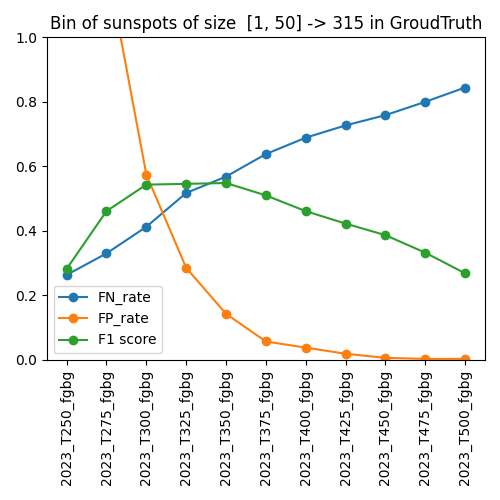

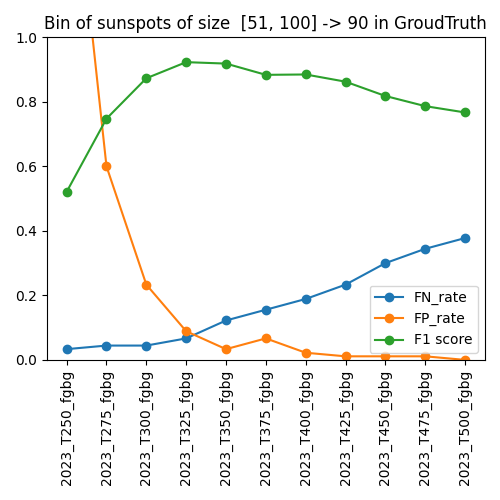

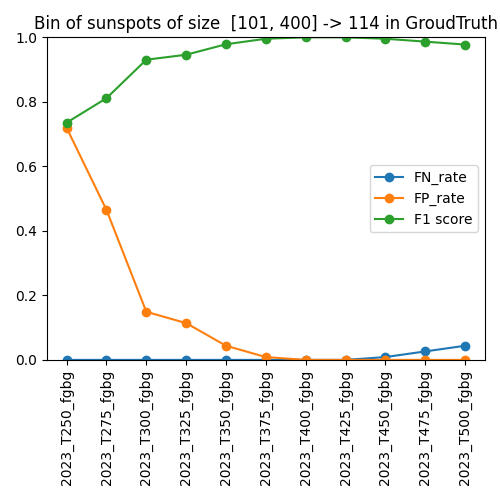

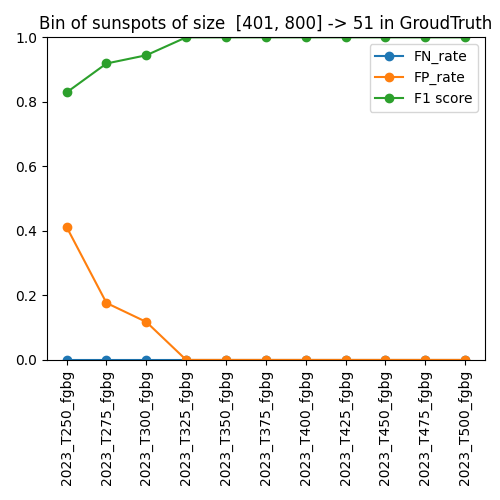

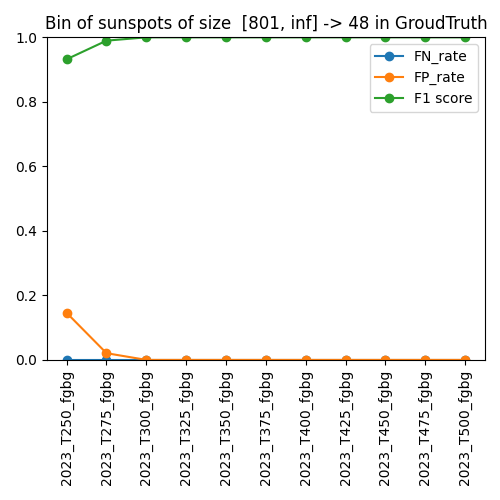

In [19]:
import scipy
import pandas as pd
from IPython.display import display

seg_to_compare = gen_seg_types

int_format = ["num_FN", "num_FP", "FP_area"]
float_format = ["percent_FN","percent_FP"]

all_classes = {'foreground':[1,2], 
#                'penumbra':[1], 
#                'umbra':[2]
              }
bins_stats = compare_generators_stats(seg_to_compare, score_per_segmenter["generators"], FP_per_segmenter["generators"], metric="DICE", all_classes=all_classes)

all_classes = {
    'foreground':[1,2], 
#     'penumbra':[1],
#     'umbra':[2]
              }
for c_name, c_ids in (pbar :=tqdm(all_classes.items(), leave=False)):
    print(c_name,c_ids)
    for i in range(len(bins)):
        df = pd.DataFrame.from_dict(bins_stats[c_name][i])#.astype(float)
        
        #F1 
        F1 = df.transpose()["F1"].to_numpy()
    
        # Roc curves
        FN_rate = df.transpose()["percent_FN"].to_numpy()
        print(FN_rate)
        FP_rate = df.transpose()["percent_FP"].to_numpy()
        
        #plot FP and FN rates along their index in a single plot, add a legend, set ticks vertically
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
        ax.set_title(f"Bin of sunspots of size  {bins[i]} -> {len(binned_gt[i])} in GroudTruth")
        ax.plot( seg_to_compare, FN_rate*0.01, marker='o')
        ax.plot( seg_to_compare, FP_rate*0.01, marker='o')
        ax.plot( seg_to_compare, F1, marker='o')
        ax.legend(['FN_rate', 'FP_rate', 'F1 score'])
        ax.set_ylim([0,1])
        # set x_label vertically
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)
        fig.tight_layout()
        
        for row in df.index:
            if row in float_format:
                df.loc[row] = df.loc[row].map('{:,.2f}'.format)
            elif row in int_format:
                df.loc[row] = df.loc[row].map('{:,.0f}'.format)

        styler = df.transpose().style
        styles = [dict(selector="caption", props=[("text-align", "center"),
                                              ("font-size", "120%"),
                                              ("font-weight", "bold")])]
        styler.set_caption(f"Bin of sunspots of size  {bins[i]} -> {len(binned_gt[i])} in GroudTruth").set_table_styles(styles)
        styler.set_properties(**{'text-align': 'center'})
        display(styler)
    #     display(df.transpose())
    

    

['2023_T250_fgbg', '2023_T275_fgbg', '2023_T300_fgbg', '2023_T325_fgbg', '2023_T350_fgbg', '2023_T375_fgbg', '2023_T400_fgbg', '2023_T425_fgbg', '2023_T450_fgbg', '2023_T475_fgbg', '2023_T500_fgbg']


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/scratch/nsayez/48019985/ipykernel_1499137/1518082902.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[a,b].axhline(y=(df4.iloc[0])[0], color='g', linestyle='--')
/scratch/nsayez/48019985/ipykernel_1499137/1518082902.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[a,b].axhline(y=(df4.iloc[0])[0], color='g', linestyle='--')
/scratch/nsayez/48019985/ipykernel_1499137/1518082902.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser

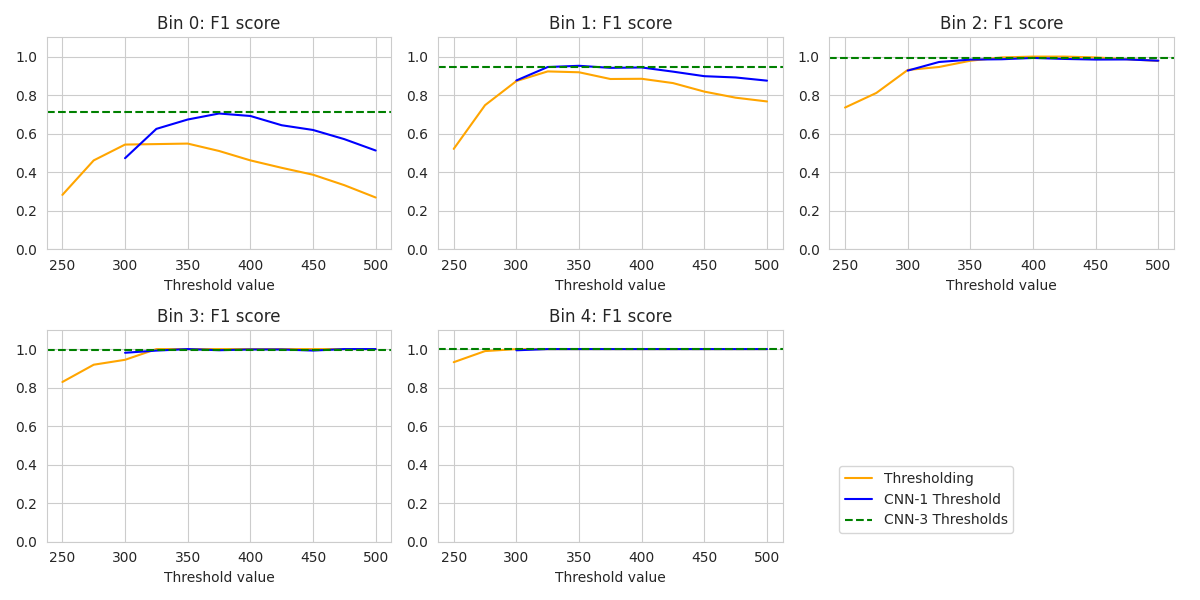

In [52]:
##### import scipy
import pandas as pd
import seaborn as sns

gen_to_compare = [k for k,v in score_per_segmenter['generators'].items()]#[2:]
print(gen_to_compare)
bins_stats_gen = compare_generators_stats(gen_to_compare, score_per_segmenter["generators"], FP_per_segmenter["generators"], metric="DICE", all_classes=all_classes)
names_gen = []
th_vals_gen = []
num_th_gen = []
for seg in score_per_segmenter["generators"].keys():
    reg_finder = re.search('2023_(.*)_fgbg', seg)
    names_gen.append(f'{reg_finder.group(1).split("_")}')
    
    reg_finder2 = re.findall('T([0-9]+)', reg_finder.group(1))
    th_vals_gen.append([int(x) for x in reg_finder2])
    num_th_gen.append(len(reg_finder2))

####################################
seg_to_compare = [k for k,v in score_per_segmenter['predictors'].items()]
show_names = []
th_vals = []
run_numbers = []
num_ttas = []
for seg in seg_to_compare:
    reg_finder = re.search('CNN-UNet_(.*)_run(.+)_(.)TTA', seg)
    show_names.append(f'CNN-{reg_finder.group(1).split("_")}')
    run_numbers.append(reg_finder.group(2))
    num_ttas.append(reg_finder.group(3))
    
    reg_finder2 = re.findall('T([0-9]+)', reg_finder.group(1))
    th_vals.append([int(x) for x in reg_finder2])

num_TH = [len(n.split(',')) for n in show_names]
# print(run_numbers)
# print(num_TH)
# print(show_names)
# print(num_ttas)
####################################

# seg_to_compare_TTA = [k for k,v in score_per_segmenter['predictors_TTA'].items()]
# show_names_TTA = []
# th_vals_TTA = []
# run_numbers_TTA = []
# num_ttas_TTA = []
# confidence_TTA = []
# for seg in seg_to_compare_TTA:
#     reg_finder = re.search('CNN-UNet_(.*)_run(.+)_(.)TTA_conf(.*)', seg)
#     show_names_TTA.append(f'CNN-{reg_finder.group(1).split("_")}_conf{reg_finder.group(4)}')
#     run_numbers_TTA.append(reg_finder.group(2))
#     num_ttas_TTA.append(reg_finder.group(3))
#     confidences_pred_TTA.append(float(reg_finder.group(4)) )
    
#     reg_finder2 = re.findall('T([0-9]+)', reg_finder.group(1))
#     th_vals_TTA.append([int(x) for x in reg_finder2])

# num_TH_TTA = [len(n.split(',')) for n in show_names_TTA]
# # print(run_numbers_TTA)
# # print(num_TH_TTA)
# # print(show_names_TTA)
####################################@
index_lists = [[index for (index, item) in enumerate(num_TH) if item == i] for i in [1,2,3]]

int_format = ["num_FN", "num_FP", "FP_area"]
float_format = ["percent_FN","percent_FP"]

all_classes = {
    'foreground':[1,2], 
#     'penumbra':[1],
#     'umbra':[2]
              }

bins_stats_pred = compare_generators_stats(seg_to_compare, score_per_segmenter["predictors"], FP_per_segmenter["predictors"], metric="DICE",all_classes=all_classes)
# bins_stats_pred_TTA = compare_generators_stats(seg_to_compare_TTA, score_per_segmenter["predictors_TTA"], FP_per_segmenter["predictors_TTA"], metric="DICE",all_classes=all_classes)

sns.set_style(style='whitegrid')
nrows = 2
# nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows))

for c_name, c_ids in (pbar :=tqdm(all_classes.items(), leave=False)):
#     print(c_name,c_ids)
    # for i in range(len(bins)-1):
    for i in range(len(bins)):
        a,b = i//ncols, i%ncols
        
        df = pd.DataFrame.from_dict(bins_stats_pred[c_name][i])#.astype(float)
        df2 = df.transpose()

        df2['run_name'] = show_names
        df2['run_number'] = run_numbers
        df2['num_th'] = num_TH
        df2['num_tta'] = num_ttas
        df2['th0_val'] = [int(np.median(t)) for t in th_vals]

        
        for f in int_format:
            df2[f]=df2[f].astype(int)
        for f in float_format:
            df2[f]=df2[f].astype(float)
        for f in ['F1','th0_val','num_tta','num_th','run_number']:
            df2[f] = pd.to_numeric(df2[f])
        df2.index = range(len(th_vals))
        df2["percent_FN"] = 0.01*df2["percent_FN"]
        df2["percent_FP"] = 0.01*df2["percent_FP"]
        
        #F1 
        F1 = df.transpose()["F1"].to_numpy()
    
        # Roc curves
        FN_rate = df.transpose()["percent_FN"].to_numpy()
        FP_rate = df.transpose()["percent_FP"].to_numpy()
    
        # show the F1 scores of single-thresholds
        df3 = df2.loc[df2['num_th'] == 1]


        ########## Compare Thresholding with CNN-1threshold
        df_gen = pd.DataFrame.from_dict(bins_stats_gen[c_name][i]) 
        df_gen = df_gen.transpose() 
        df_gen['name'] = names_gen
        df_gen['th0_val'] = [np.median(t) for t in th_vals_gen]
        
        for f in int_format:
            df_gen[f]=df_gen[f].astype(int)
        for f in float_format:
            df_gen[f]=df_gen[f].astype(float)
            
        g = sns.lineplot(
            data=df_gen,
            x="th0_val", y="F1",
            ax=ax[a,b],
            color='orange',
            label='Thresholding'
        )
        g.set_ylim([0,1.1])
        
        g = sns.lineplot(
                    data=df3,
                    x="th0_val", y="F1",
#                     ci=None,
                    errorbar=None,
                    ax=ax[a,b],
                    color='blue',
                    label='CNN-1 Threshold'
                )
        
        ######## Add CNN-Multithreshold
        
        df4 = df2.loc[df2['num_th'] > 1]#.drop(['B', 'C'], axis=1)
        df4 = df4.loc[df4['run_number'] > 3]
        
        df4 = df4.groupby(['run_name']).mean()  
        ax[a,b].axhline(y=(df4.iloc[0])[0], color='g', linestyle='--')   
#         ax[a,b].axhline(y=df4['F1'][0], color='g', linestyle='--')        
        ax[a,b].get_legend().remove()
        ax[a,b].set_title(f'Bin {i}: F1 score')
        ax[a,b].set_xlabel('Threshold value')
        ax[a,b].set_ylabel('')


        fig.tight_layout()
        

ax[-1,-1].remove()
# ax[-1,-2].remove()

orange_line = mlines.Line2D([], [], color='orange', marker='None', linestyle='-',
                          markersize=10, label='Thresholding')
blue_line = mlines.Line2D([], [], color='blue', marker='None', linestyle='-',
                          markersize=10, label='CNN-1 Threshold')
green_cross = mlines.Line2D([], [], color='green',  linestyle='--',
                          markersize=10, label='CNN-3 Thresholds')

fig.legend(handles=[orange_line, blue_line, green_cross],loc='lower right', bbox_to_anchor=(.85, .1) )
    
plt.savefig(f"F1Score_All_bins.pdf", format="pdf", bbox_inches="tight")
    

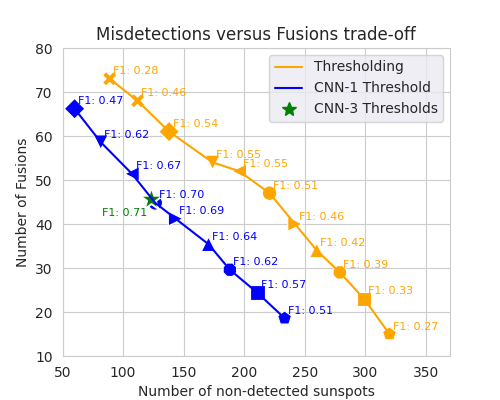

In [80]:
import seaborn as sns
import re 
import itertools
import matplotlib.lines as mlines
sns.set_style(style='whitegrid')

def compute_fps_fusions_matches(big_dict, gen, c_name):
    FPs = []
    FNs = []
    Matches = []
    Fusions = []
    Fusions_V2 = []
    
    for img_key, img_stats in big_dict[gen][c_name].items():
        cur_img_FP = np.sum(img_stats['FP'])
        cur_img_FN = np.sum(img_stats['FN'])
        cur_img_Fusions = np.sum([v for v in img_stats['Fusions'] if v > 1])
        cur_img_Fusions_V2 = np.sum([1 for v in img_stats['Fusions'] if v > 1])
        cur_img_Matches = np.sum([1 for v in img_stats['Fusions'] if v == 1])

        FPs.append(cur_img_FP)
        FNs.append(cur_img_FN)
        Matches.append(cur_img_Matches)
        Fusions.append(cur_img_Fusions)
        Fusions_V2.append(cur_img_Fusions_V2)
        
    return {'tot_FPs': np.sum(FPs), 'tot_FNs': np.sum(FNs), 'tot_Matches': np.sum(Matches), 
            'tot_Fusions': np.sum(Fusions), 'tot_Fusions_V2': np.sum(Fusions_V2),
           'FPs': FPs, 'Matches': Matches, 'Fusions': Fusions, 'Fusions_V2': Fusions_V2}
        
names_gen = []
th_vals_gen = []
num_th_gen = []
for seg in fusions_per_generator.keys():
    reg_finder = re.search('2023_(.*)_fgbg', seg)
    names_gen.append(f'{reg_finder.group(1).split("_")}')
    
    reg_finder2 = re.findall('T([0-9]+)', reg_finder.group(1))
    th_vals_gen.append([int(x) for x in reg_finder2])
    num_th_gen.append(len(reg_finder2))

####################################

names_pred = []
th_vals_pred = []
run_numbers_pred = []
num_ttas_pred = []
num_th_pred = []
for seg in fusions_per_predictor.keys():
    reg_finder = re.search('CNN-UNet_(.*)_run(.+)_(.)TTA', seg)
    names_pred.append(f'CNN-{reg_finder.group(1).split("_")}')
    run_numbers_pred.append(reg_finder.group(2))
    num_ttas_pred.append(reg_finder.group(3))
    
    reg_finder2 = re.findall('T([0-9]+)', reg_finder.group(1))
    th_vals_pred.append([int(x) for x in reg_finder2])
    num_th_pred.append(len(reg_finder2))

####################################

# names_pred_TTA = []
# th_vals_pred_TTA = []
# run_numbers_pred_TTA = []
# num_ttas_pred_TTA = []
# num_th_pred_TTA = []
# confidences_pred_TTA = []
# for seg in fusions_per_predictor_TTA.keys():
# #     print(seg)
#     reg_finder = re.search('CNN-UNet_(.*)_run(.+)_(.)TTA_conf(.*)', seg)
#     names_pred_TTA.append(f'{reg_finder.group(1).split("_")}_conf{reg_finder.group(4)}')
#     run_numbers_pred_TTA.append(reg_finder.group(2))
#     num_ttas_pred_TTA.append(reg_finder.group(3))
#     confidences_pred_TTA.append(float(reg_finder.group(4)) )
    
#     reg_finder2 = re.findall('T([0-9]+)', reg_finder.group(1))
#     th_vals_pred_TTA.append([int(x) for x in reg_finder2])
#     num_th_pred_TTA.append(len(reg_finder2))


new_stats_gen = { k: compute_fps_fusions_matches(fusions_per_generator, k, 'foreground') for k, v  in fusions_per_generator.items()}
new_stats_pred = { k: compute_fps_fusions_matches(fusions_per_predictor, k, 'foreground') for k, v  in fusions_per_predictor.items()}
# new_stats_pred_TTA = { k: deepcopy(compute_fps_fusions_matches(fusions_per_predictor_TTA, k, 'foreground')) 
#                                   for k, v  in fusions_per_predictor_TTA.items()}

df_fus_miss_gen = pd.DataFrame(new_stats_gen).transpose()
df_fus_miss_pred = pd.DataFrame(new_stats_pred).transpose()
# df_fus_miss_pred_TTA = pd.DataFrame(new_stats_pred_TTA).transpose()

for f in ['tot_FPs','tot_FNs','tot_Fusions','tot_Fusions_V2','tot_Matches']:
    df_fus_miss_gen[f]=df_fus_miss_gen[f].astype(int)
    df_fus_miss_pred[f]=df_fus_miss_pred[f].astype(int)
#     df_fus_miss_pred_TTA[f]=df_fus_miss_pred_TTA[f].astype(int)
    
df_fus_miss_gen['name'] = names_gen
df_fus_miss_pred['name'] = names_pred
df_fus_miss_pred['run_number'] = run_numbers_pred
df_fus_miss_pred['num_ttas'] = num_ttas_pred
df_fus_miss_pred['num_th'] = num_th_pred

# df_fus_miss_pred_TTA['name'] = names_pred_TTA
# df_fus_miss_pred_TTA['run_number'] = run_numbers_pred_TTA
# df_fus_miss_pred_TTA['num_ttas'] = num_ttas_pred_TTA
# df_fus_miss_pred_TTA['num_th'] = num_th_pred_TTA
# df_fus_miss_pred_TTA['confidence'] = confidences_pred_TTA

df_fus_miss_pred = df_fus_miss_pred.groupby(['name']).mean(numeric_only=True)

fig_fus_miss, ax_fus_miss = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
sns.set_style("darkgrid")
g_l = sns.lineplot(
            data=df_fus_miss_gen,
            x="tot_FNs", y="tot_Fusions_V2",
            ax=ax_fus_miss,
            color='orange',
            label='Thresholding'
    )

tmp = pd.DataFrame(bins_stats_gen[c_name][0])
for entry in tmp:
    coord = df_fus_miss_gen.loc[entry]
    x, y=coord['tot_FNs' ],coord['tot_Fusions_V2']
    f1 = tmp[entry]['F1']
    t = 'F1: {:.2f}'.format(f1)
    ax_fus_miss.text(x+3,y+1, t, size=8, c='orange')

marker = itertools.cycle([  'D', 'v', '<', 'o', '>','^', '8', 's', 'p', 'X', 'X', 'D', 'd', 'P', 'X'])
markers = [next(marker) for i in df_fus_miss_gen["name"].unique()]
# print(markers)
sns.scatterplot(data=df_fus_miss_gen,
                x='tot_FNs', y='tot_Fusions_V2', 
                style='name',
                s=110,
                color='orange',
                markers = markers,
               )

p_l = sns.lineplot(
            data=df_fus_miss_pred.loc[df_fus_miss_pred['num_th'] == 1],
            x="tot_FNs", y="tot_Fusions_V2",
            ax=ax_fus_miss,
            color='blue'
    )

marker_CNN = itertools.cycle([  'D', 'v', '<', 'o', '>','^', '8', 's', 'p', 'X', 'X', 'D', 'd', 'P', 'X'])
markers_CNN = [next(marker_CNN) for i in df_fus_miss_pred.loc[df_fus_miss_pred['num_th'] == 1].index]

p_s = sns.scatterplot(data=df_fus_miss_pred.loc[df_fus_miss_pred['num_th'] == 1],
                x='tot_FNs', y='tot_Fusions_V2', 
                style='name',
                s=110,
                markers=markers_CNN,
                color='blue',
                ax=ax_fus_miss,
               )

tmp = pd.DataFrame(bins_stats_pred[c_name][0])

tmp2 = tmp.transpose()
tmp2["run_name"] = names_pred
tmp2["num_th"] = num_th_pred

tmp3 = tmp2.loc[tmp2['num_th'] == 1]
tmp4 = tmp3.groupby('run_name').mean()

for entry in tmp4.transpose():
    coord = df_fus_miss_pred.loc[entry]
    x, y=coord['tot_FNs' ],coord['tot_Fusions_V2']
    f1 = tmp4.transpose()[entry]['F1']
    t = 'F1: {:.2f}'.format(f1)
    ax_fus_miss.text(x+3,y+1, t, size=8, c='blue')
    

tmp3 = tmp2.loc[tmp2['num_th'] == 3]
tmp4 = tmp3.groupby('run_name').mean()

for entry in tmp4.transpose():
    coord = df_fus_miss_pred.loc[entry]
    x, y=coord['tot_FNs' ],coord['tot_Fusions_V2']
    f1 = tmp4.transpose()[entry]['F1']
    t = 'F1: {:.2f}'.format(f1)
    ax_fus_miss.text(x-3,y-2, t, size=8, c='g', va='top', ha='right')

p_s3 = sns.scatterplot(data=df_fus_miss_pred.loc[df_fus_miss_pred['num_th'] == 3],
                x='tot_FNs', y='tot_Fusions_V2', 
                s=300,
                marker='*',
                color='green'
               )

# pal1 = sns.color_palette('Greens', df_fus_miss_pred.count().iloc[0])
# pal2 = sns.color_palette('Blues', df_fus_miss_pred.count().iloc[0])
# # pal1 = sns.color_palette('Greens', df_fus_miss_pred_TTA.count()[0])
# # pal2 = sns.color_palette('Blues', df_fus_miss_pred_TTA.count()[0])

ax_fus_miss.set_xlabel('Number of non-detected sunspots')
ax_fus_miss.set_ylabel('Number of Fusions')

ax_fus_miss.legend([],[], frameon=False)

ax_fus_miss.patch.set_edgecolor('black')  
# ax_fus_miss.patch.set_linewidth('1') 

ax_fus_miss.set_xlim([50, 370])
ax_fus_miss.set_ylim([10, 80])

orange_line = mlines.Line2D([], [], color='orange', marker='None', linestyle='-',
                          markersize=10, label='Thresholding')
blue_line = mlines.Line2D([], [], color='blue', marker='None', linestyle='-',
                          markersize=10, label='CNN-1 Threshold')
green_cross = mlines.Line2D([], [], color='green', marker='*', linestyle='None',
                          markersize=10, label='CNN-3 Thresholds')

# fig_fus_miss.legend([g_l, p_l, p_s3] , labels=['Thresholding','CNN-1 Threshold', 'CNN-3 Threshold'])


ax_fus_miss.legend(handles=[orange_line, blue_line, green_cross])


ax_fus_miss.set_title('Misdetections versus Fusions trade-off')


# fig_fus_miss.tight_layout()

plt.savefig("UndetectedVSFusions.pdf", format="pdf", bbox_inches="tight")
plt.show()

a = df_fus_miss_gen['tot_FNs'][:-2]
b = df_fus_miss_pred.loc[df_fus_miss_pred['num_th'] == 1]['tot_FNs']
c = a-b.values
d = c / a.values
# print(a)
# print(b)
# print(c)
# print(d)

# print()

a = df_fus_miss_gen['tot_Fusions_V2'][:-2]
b = df_fus_miss_pred.loc[df_fus_miss_pred['num_th'] == 1]['tot_Fusions_V2']
c = b-a.values
d = c / a.values
# print(a)
# print(b)
# print(c)
# print(d)




# Look at distribution of False positives among Test images

In [ ]:
# Distribution of FPs along images
def get_FP_distribution(seg_to_compare, FP_per_segmenter):
    
    distributions = {}
    
    for seg in tqdm(seg_to_compare):
        cur_FPs = FP_per_segmenter[seg]
        
        cur_class_FPs = cur_FPs['foreground']
        cur_images = {}

        for b, bin_FPs  in cur_class_FPs.items():
            for FP in bin_FPs['false_positives']:

                if FP['image'] not in cur_images:
                    cur_images[FP['image']] = 0

                cur_images[FP['image']] += 1

        distributions[seg] = cur_images

    return distributions

distros = get_FP_distribution(seg_to_compare, FP_per_segmenter['predictors'])

for k,v in distros.items():
    all_im_distro = {os.path.basename(test_im).split('.')[0] :0 for test_im in gt_lst }
    for  im , num_fp in v.items():
        all_im_distro[im] += num_fp
        
    plt.figure(figsize=(5,2))
    plt.title(k)
    plt.xticks(range(len(all_im_distro.keys())),rotation=90)
    plt.bar(range(len(all_im_distro.keys())), all_im_distro.values(), .5, color='g')
    plt.tight_layout()
        
    